In [1]:
"""
CVaR.py>
"""
import numpy as np
import math
from scipy.optimize import minimize
from scipy.stats.distributions import chi2
from numpy import linalg
from scipy.stats import gmean
from scipy.optimize import linprog
from scipy.stats import norm
from scipy import stats

# ----- function: CVaR model ------
"""
min     gamma + (1 / [(1 - alpha) * S]) * sum( z_s )
s.t.    z_s   >= 0,                 for s = 1, ..., S
        z_s   >= -r_s' x - gamma,   for s = 1, ..., S
        1' x  =  1,
        mu' x >= R
"""

def CVaR(returns, alpha):
    if returns.shape[1] == 1:
        x = np.asmatrix(1)
    else:
        mu = gmean(returns+1) - 1  # Estimate the geometric mean
        R = 1.1 * np.mean(mu)  # Set our target return
        t, p = returns.shape  # Determine the number of assets and scenarios
        # formulate the linear program
        # bound
        lst_t = np.ones(t)
        lst_p = np.ones(p)
        bounds = tuple((0, None) for i in lst_p) + tuple((0, None) for i in lst_t) + \
                 tuple((-math.inf, None) for i in np.ones(1))
        # inequality constraint matrix A and vector b
        A = np.vstack((np.hstack((-returns, -np.identity(t), -np.ones((t, 1)))),
                      np.hstack((-mu[np.newaxis], np.zeros((1, t)), np.zeros((1, 1))))))
        b = np.vstack((np.zeros((t, 1)), -R[np.newaxis]))
        # equality constraint matrix Aeq and vector beq
        Aeq = np.hstack((np.ones((1, p)), np.zeros((1, t)), np.zeros((1, 1))))
        beq = 1
        # coefficient of variables
        k = 1 / ((1 - alpha) * t)
        c = np.vstack((np.zeros((p, 1)), k*np.ones((t, 1)), np.ones((1, 1))))
        # linprog optimizer
        res = linprog(c, A_ub=A, b_ub=b, A_eq=Aeq, b_eq=beq, bounds=bounds)
        x = np.asmatrix(res.x[:p])
    
    return x

In [2]:
"""
OLS.py>
"""

import numpy as np
from numpy.linalg import inv

# ----- function: OLS regression model ------
def OLS(returns, factRet):
    t, p = factRet.shape  # Number of observations and factors
    factRet = factRet.to_numpy(dtype=np.float64)
    returns = returns.to_numpy()
    X = np.hstack((np.ones((t, 1), dtype=np.float64), factRet))  # factor matrix;
    B = np.dot(np.dot(inv(np.dot(X.T, X)), X.T), returns)  # Regression coefficients;
    # separate B into alpha and betas
    a = B[0, :]
    V = B[1:, :]

    # residual variance
    ep = returns - np.dot(X, B)
    ep_2_sum = np.sum(ep ** 2, axis=0)  # sum each matrix column
    sigma_ep = 1 / (t - p - 1) * ep_2_sum
    D = np.diag(sigma_ep)

    # factor expected returns and covariance matrix
    f_bar = np.mean(factRet, axis=0)
    F = np.cov(factRet, rowvar=False)

    # Calc. asset expected returns and covariance matrices
    mu = a + np.dot(V.T, f_bar)
    Q = np.dot(np.dot(V.T, F), V) + D
    Q = (Q + Q.T) / 2

    # calc. adjusted R-squared
    r_bar = np.mean(returns, axis=0)
    RSS = ep_2_sum
    TSS = np.sum((returns - r_bar) ** 2, axis=0)
    R2 = 1 - RSS / TSS
    adj_R2 = 1 - (1 - R2) * ((t - 1) / (t - p - 1))
    adj_R2_bar = np.mean(adj_R2)

    return mu, Q, adj_R2_bar

In [3]:
"""
RP.py>
"""

import numpy as np
from scipy.optimize import minimize

# ----- function: Risk Parity model ------

# risk budgeting optimization
def calculate_portfolio_var(x, Q):
    # function that calculates portfolio risk
    x = np.matrix(x)
    return (x * (Q * x.T))[0, 0]

def calculate_risk_contribution(x, Q):
    # function that calculates asset contribution to total risk
    x = np.matrix(x)
    sigma = np.sqrt(calculate_portfolio_var(x, Q))
    # Marginal Risk Contribution
    MRC = Q * x.T
    # Risk Contribution
    RC = np.multiply(MRC, x.T)/sigma
    return RC

def risk_budget_objective(x, pars):
    # calculate portfolio risk
    Q = pars[0]  # covariance table
    x_targ = pars[1]  # risk target in percent of portfolio risk
    sig_p = np.sqrt(calculate_portfolio_var(x, Q))  # portfolio sigma
    risk_target = np.asmatrix(np.multiply(sig_p, x_targ))
    asset_RC = calculate_risk_contribution(x, Q)
    J = sum(np.square(asset_RC-risk_target.T))[0, 0]  # sum of squared error
    return J

def total_weight_constraint(x):
    return np.sum(x)-1.0

def long_only_constraint(x):
    return x

def RP(Q):
    p = Q.shape[0]  # number of assets
    tol = 1e-14
    x_targ = np.full(p, 1 / p)  # define initial portfolio (equal risk)
    x0 = np.random.dirichlet(np.ones(p), size=1)
    cons = ({'type': 'eq', 'fun': total_weight_constraint},
            {'type': 'ineq', 'fun': long_only_constraint})
    res = minimize(risk_budget_objective, x0=x0, args=[Q, x_targ], method='SLSQP', constraints=cons,
                   tol=tol, options={'disp': False, 'maxiter': 10000})
    x = np.asmatrix(res.x)
    return x

In [4]:
"""
robustMVO.py>
"""

import numpy as np
import math
from scipy.optimize import minimize
from scipy.stats.distributions import chi2
from numpy import linalg

# ----- function: robust MVO model ------

# model:
# min. lambda * (x' * Q * x) - mu' x + epsilon * norm (sqrtTh * x)
# s.t.  sum(x) == 1
#            x >= 0

def total_weight_constraint(x):
    return np.sum(x)-1.0

'''
def long_only_constraint(x):
    return x
'''

def sqrt_theta(Q, alpha):
    p = Q.shape[0]  # find the number of assets
    ep = math.sqrt(chi2.ppf(alpha, df=p))  # Define the radius of the uncertainty set
    theta = np.diag(np.diag(Q)) / p  # find the squared standard error of our expected returns
    sqrtTh = np.sqrt(theta)  # square root of theta
    return sqrtTh, ep

def objFn(x, pars):
    mu = pars[0]
    Q = pars[1]
    riskAver = pars[2]
    sqrtTh = pars[3]
    ep = pars[4]
    # objective function
    f = riskAver * np.dot(np.dot(x, Q), x.T) - np.dot(mu.T[np.newaxis], x.T) + ep * linalg.norm(sqrtTh * x)
    return f

def robustMVO(mu, Q, riskAver, alpha):
    p = Q.shape[0]  # find the number of assets
    sqrtTh, ep = sqrt_theta(Q, alpha)
    x0 = np.random.dirichlet(np.ones(p), size=1)[0] # initial weight
    tol = 1e-14
    cons = ({'type': 'eq', 'fun': total_weight_constraint})
    lst = np.ones(p)
    bounds = tuple((0, 1) for i in lst)
    res = minimize(objFn, x0=x0, args=[mu, Q, riskAver, sqrtTh, ep], method='SLSQP', constraints=cons,
                   bounds=bounds, tol=tol, options={'disp': False, 'maxiter': 10000})
    x = np.asmatrix(res.x)
    return x

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from openpyxl import load_workbook
import math
from datetime import datetime, timedelta
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from copulas.multivariate import VineCopula
import statsmodels.api as sm
import seaborn as sns
pd.set_option('display.max_columns', 20)

------------------Backtest-----------------------

The following two blocks of code are designed specifically for backtesting. Some inputs such as startDate and reportDate are manually set to be 2014-03-01 and 2016-03-01 respectively to fix the backtesting period. Backtest period should be before the investment period starts. We use our backtest results to compare the three asset allocation models' performance and select the optimal model.

IMPORTANT: when running backtest, we should comment out or not run code blocks [8] and [9] because they are for officially constructing the investment portfolio that starts at 2016-04-01. 

Backtest Period from 2014.3.1 to 2016.3.1
rebalancing period=24 month

In [6]:
dir = os.getcwd()  # wd

# 1. Link to the Robo Advisor UI and get user inputs
wb = load_workbook(dir + r'\AWGP_RoboAdvisor.xlsx')
ws = wb['UI']
name = ws[list(wb.defined_names['name'].destinations)[0][1]].value
age = ws[list(wb.defined_names['age'].destinations)[0][1]].value  # client age
cap = ws[list(wb.defined_names['cap'].destinations)[0][1]].value  # initial capital
startDate = ws[list(wb.defined_names['startDate'].destinations)[0][1]].value
injection = ws[list(wb.defined_names['injection'].destinations)[0][1]].value  # periodic injection amount
injectFreq = ws[list(wb.defined_names['injectFreq'].destinations)[0][1]].value
ESG = ws[list(wb.defined_names['ESG'].destinations)[0][1]].value  # whether to include ESG or not
ESGperc = ws[list(wb.defined_names['ESGperc'].destinations)[0][1]].value  # ESG percentage
caliYr = ws[list(wb.defined_names['caliYr'].destinations)[0][1]].value  # calibration period length
leverage = ws[list(wb.defined_names['leverage'].destinations)[0][1]].value  # percentage of leverage
reportDate = ws[list(wb.defined_names['reportDate'].destinations)[0][1]].value
rebalFreq = ws[list(wb.defined_names['rebalFreq'].destinations)[0][1]].value  # rebalancing frequency is every 6 months
cost = ws[list(wb.defined_names['cost'].destinations)[0][1]].value  # transaction cost per unit of ETF traded
countryPerc = ws[list(wb.defined_names['countryPerc'].destinations)[0][1]].value  # USD:CAD exposure. 50% means 50/50
equityFI_perc = ws[list(wb.defined_names['equityFI_perc'].destinations)[0][1]].value  # equity+FI percentage in portf
alpha = ws[list(wb.defined_names['alpha'].destinations)[0][1]].value  # confidence level
riskAver = ws[list(wb.defined_names['riskAver'].destinations)[0][1]].value  # risk tolerance


# Replace Parameters
startDate=datetime(2014, 3, 1)
reportDate=datetime(2016, 3, 1)
caliYr=8
rebalFreq=24 # prevent rebalancing in backtesting
injectFreq = 100 # don't inject


# 2. Link to the investment pool (ESG + non_ESG ETFs) and factors
# data is from 2007/01/01

# ETFs
df_ESG = pd.read_excel(dir + r'\ESG_Prices.xlsx', sheet_name='Prices', index_col=0, engine='openpyxl')
df_nonESG = pd.read_excel(dir + r'\NonESG_Prices.xlsx', sheet_name='Prices', index_col=0, engine='openpyxl')
df_nonESG = df_nonESG.loc[:, ~df_nonESG.columns.str.contains('^Unnamed')]
ret_ESG = df_ESG.pct_change().iloc[1:].loc[:reportDate]
ret_nonESG = df_nonESG.pct_change().iloc[1:].loc[:reportDate]

# select ETFs with low correlations
def select_ETF(df1, df2):
    df = df1.copy()
    cor = df.corr().abs()
    # Select upper/lower triangle of correlation matrix
    upper_triangle = cor.where(np.triu(np.ones(cor.shape), k=1).astype(bool))
    # Find features with correlation greater than 0.85
    drop_lst1 = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.8)]
    print('number of features dropped that have high correlations: ' + str(len(drop_lst1)))
    # Drop features
    df2.drop(drop_lst1, axis=1, inplace=True)
    print('number of features left: ' + str(len(df2.columns)))
    return df2

ret_ESG = select_ETF(ret_ESG.loc[:startDate], ret_ESG)
ret_nonESG = select_ETF(ret_nonESG.loc[:startDate], ret_nonESG)

# dates and tickers
dates = ret_ESG.index  # all dates of our dataset
tickers_nonESG = list(ret_nonESG.columns)
tickers_ESG = list(ret_ESG.columns)
df_ESG = pd.DataFrame(df_ESG, columns=tickers_ESG)  # ESG dataframe
df_nonESG = pd.DataFrame(df_nonESG, columns=tickers_nonESG)  # non-ESG dataframe
print("nonESG ETFs left:" + str(tickers_nonESG))
print("ESG ETFs left:" + str(tickers_ESG))


# ----- input: final selected ETFs - need to update the list manually according to the above print output ------
allocation_model = 'RP'
tickers_nonESG_equity_FI_USD = ['XNTK', 'KCE', 'XLE', 'XLV', 'XLU', 'SHY', 'TLT', 'TIP', 'LQD', 'MHWIX']
tickers_nonESG_other_USD = ['GLD', 'GSG']
tickers_nonESG_equity_FI_CAD = ['XIT.TO', 'XBB.TO', 'XRB.TO']
tickers_nonESG_other_CAD = ['XRE.TO']
tickers_ESG_equity_USD = ['XLB']
# --------------------------------------------------------------------------------------------------------------

number of features dropped that have high correlations: 3
number of features left: 1
number of features dropped that have high correlations: 20
number of features left: 16
nonESG ETFs left:['XNTK', 'KCE', 'XLE', 'XLV', 'XLU', 'XIT.TO', 'SHY', 'TLT', 'TIP', 'LQD', 'XBB.TO', 'XRB.TO', 'XRE.TO', 'GLD', 'MHWIX', 'GSG']
ESG ETFs left:['XLB']


portfolio value evolution:[ 99468.19159776 100471.20154537 101140.38469952 101907.47750538
 100613.48357082 103493.96988145 100867.13787877 102816.4286268
 104080.32426163 104013.38809727 109138.62093932 117096.73099648
 113043.79672659 114929.96960089 110890.66923691 110117.40564976
 109662.46374647 109214.97560521 106983.99817438 111429.38472671
 110147.2075132  109861.51545412 109455.38802039 113465.81839735
 115155.36176526]
       XNTK       KCE       XLE       XLV      XLU       SHY       TLT  \
0  0.014209  0.004661  0.005575  0.008453  0.00891  0.099813  0.008399   

        TIP       LQD     MHWIX       GLD       GSG    XIT.TO    XBB.TO  \
0  0.016572  0.013293  0.020117  0.054548  0.045452  0.045532  0.252824   

     XRB.TO  XRE.TO  XLB  
0  0.101644     0.1  0.2  
turnover:[0.]
adjusted R-squared:[0.08005897]
date:DatetimeIndex(['2014-03-01', '2014-04-01', '2014-05-01', '2014-06-01',
               '2014-07-01', '2014-08-01', '2014-09-01', '2014-10-01',
               '2014

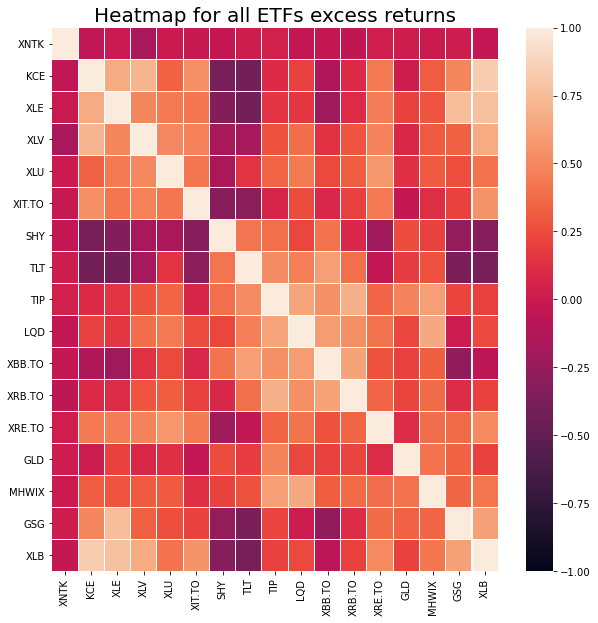

In [7]:
# factors
factors = pd.read_csv(dir + r'\FF_5_Factor.csv', index_col=0,parse_dates=True)
factors = factors.loc[dates]
rf = pd.DataFrame(factors['RF'], columns=['RF'])  # risk-free rate data
ret_factor = factors.drop('RF', axis=1)  # factor returns data
rf.set_index(dates, inplace=True)
ret_factor.set_index(dates, inplace=True)

# CAD/USD FX rate
FX = pd.read_csv(dir + r'\USD_CAD_Historical_Data.csv', index_col=0,parse_dates=True)  # FX rate
FX = FX.loc[dates]

# Excess Return
exRet_nonESG = ret_nonESG.sub(rf['RF'], 0)  # non ESG ETFs excess return dataset
exRet_ESG = ret_ESG.sub(rf['RF'], 0)

# leverage
init_cap = cap * (1+leverage)  # total initial capital including leverage  # initial capital + leverage
loan = cap * leverage  # loan at start of investment period; interest rate = RFR

# 3. system implementation
exRet_portf = exRet_nonESG.copy()  # portfolio excess return dataset for non ESG ETFs
# separate by asset class
exRet_equity_FI_USD = pd.DataFrame(exRet_portf, columns=tickers_nonESG_equity_FI_USD)
exRet_other_USD = pd.DataFrame(exRet_portf, columns=tickers_nonESG_other_USD)
exRet_equity_FI_CAD = pd.DataFrame(exRet_portf, columns=tickers_nonESG_equity_FI_CAD)
exRet_other_CAD = pd.DataFrame(exRet_portf, columns=tickers_nonESG_other_CAD)

if ESG == 'No':
    price_portf = df_nonESG.iloc[1:].loc[:reportDate].copy()  # investment portfolio's monthly price dataset for non ESG
    # apply FX on USD non ESG ETFs price
    price_portf[tickers_nonESG_equity_FI_USD + tickers_nonESG_other_USD] = \
        price_portf[tickers_nonESG_equity_FI_USD + tickers_nonESG_other_USD].mul(FX['Price'], axis=0)
    price_portf = pd.concat([price_portf[tickers_nonESG_equity_FI_USD], price_portf[tickers_nonESG_other_USD],
                             price_portf[tickers_nonESG_equity_FI_CAD], price_portf[tickers_nonESG_other_CAD]],
                            axis=1).copy()

if ESG == 'Yes':
    price_portf = pd.concat([df_nonESG, df_ESG], axis=1).iloc[1:].loc[:reportDate].copy()  # non ESG+ESG ETFs price data
    exRet_portf = pd.concat([exRet_nonESG, exRet_ESG], axis=1).copy()  # non ESG+ESG ETFs excess return data
    # ESG ETFs returns
    exRet_ESG_equity_FI_USD = pd.DataFrame(exRet_portf, columns=tickers_ESG_equity_USD)
    # apply FX on USD ETFs for both non ESG and ESG
    price_portf[tickers_nonESG_equity_FI_USD + tickers_nonESG_other_USD + tickers_ESG_equity_USD] = \
        price_portf[tickers_nonESG_equity_FI_USD + tickers_nonESG_other_USD + tickers_ESG_equity_USD].mul(FX['Price'],
                                                                                                          axis=0)
    price_portf = pd.concat([price_portf[tickers_nonESG_equity_FI_USD], price_portf[tickers_nonESG_other_USD],
                             price_portf[tickers_nonESG_equity_FI_CAD], price_portf[tickers_nonESG_other_CAD],
                             price_portf[tickers_ESG_equity_USD]],
                            axis=1).copy()


n = exRet_portf.shape[1]  # number of ETFs in the portfolio
n_equity_FI_USD = exRet_equity_FI_USD.shape[1]  # number of USD ETFs (equity+FI)
n_other_USD = exRet_other_USD.shape[1]  # number of USD ETFs (equity+FI)
n_equity_FI_CAD = exRet_equity_FI_CAD.shape[1]  # number of CAD ETFs (equity+FI)
n_other_CAD = exRet_other_CAD.shape[1]  # number of CAD ETFs (equity+FI)
n_ESG_equity_FI_USD = exRet_ESG_equity_FI_USD.shape[1]  # number of ESG USD ETFs (equity+FI)
testStart = exRet_portf.loc[startDate:].index[0]  # each rebalancing period start date
# testEnd = exRet_portf.loc[startDate:].index[rebalFreq] - timedelta(days=1)   # each rebalancing period end date
testEnd=reportDate
caliEnd = testStart - timedelta(days=1)  # the end of each calibration period
NoPeriods = math.ceil((len(exRet_portf.loc[startDate:]) - 1) / rebalFreq)  # number of rebalancing periods
testMonths = len(exRet_portf.loc[startDate:])  # number of months in the test period
testDate = exRet_portf.loc[startDate:].index  # all dates in the test period


# Preallocate space
x_equity_FI_USD = np.zeros((n_equity_FI_USD, NoPeriods))  # USD equity + FI non ESG ETFs weight
x_other_USD = np.zeros((n_other_USD, NoPeriods))  # USD REIT + commodity non ESG ETFs weight
x_equity_FI_CAD = np.zeros((n_equity_FI_CAD, NoPeriods))  # CAD equity + FI non ESG ETFs weight
x_other_CAD = np.zeros((n_other_CAD, NoPeriods))  # CAD REIT + commodity non ESG ETFs weight
x_ESG_equity_FI_USD = np.zeros((n_ESG_equity_FI_USD, NoPeriods))  # USD ESG equity ETFs weight
x = np.zeros((n, NoPeriods))  # all ETFs weights
x0 = np.zeros((n, NoPeriods))  # all ETFs weights before rebalancing
adj_R2_bar = np.zeros(NoPeriods)
NoShares = np.zeros(n)  # all ETFs number of shares before rebalancing
NoShares_new = np.zeros(n)  # all ETFs number of shares after rebalancing
currentVal = np.zeros(NoPeriods)  # last observed portfolio value during current calibration period
portfValue = np.zeros(testMonths)  # portfolio value for each month in the test period
turnover = np.zeros(NoPeriods)
testDate2 = np.zeros(NoPeriods, dtype='datetime64[ns]')  # last day during each rebalancing period

# loop through each rebalancing period
for t in range(NoPeriods):
    # excess return of portfolio for the calibration period
    ret_cali_equity_FI_USD = exRet_equity_FI_USD.loc[caliEnd-timedelta(days=caliYr*365.25):caliEnd]
    ret_cali_other_USD = exRet_other_USD.loc[caliEnd - timedelta(days=caliYr * 365.25):caliEnd]
    ret_cali_equity_FI_CAD = exRet_equity_FI_CAD.loc[caliEnd-timedelta(days=caliYr*365.25):caliEnd]
    ret_cali_other_CAD = exRet_other_CAD.loc[caliEnd - timedelta(days=caliYr * 365.25):caliEnd]
    if ESG == 'Yes':
        ret_cali_ESG_equity_FI_USD = exRet_ESG_equity_FI_USD.loc[caliEnd - timedelta(days=caliYr * 365.25):caliEnd]

    # factors return for the calibration period
    ret_factor_cali = ret_factor.loc[caliEnd-timedelta(days=caliYr*365.25):caliEnd]

    currPrice = price_portf.loc[:caliEnd].iloc[-1]  # last observed price during calibration period
    testPrice = price_portf.loc[testStart:testEnd]  # rebalancing period prices
    testPeriod = len(price_portf.loc[testStart:testEnd])
    testDate2[t] = price_portf.loc[testStart:testEnd].index[-1].value  # last day during each rebalancing period

    if t == 0:
        # last observed portfolio value during current calibration period
        currentVal[t] = init_cap
    else:
        currentVal[t] = np.dot(currPrice, NoShares) + injection - trans_cost

        # store the current asset weights (before rebalance)
        x0[:, t] = (currPrice * NoShares) / currentVal[t]

    # portfolio construction
    # factor model: OLS calibration + optimization model, apply on each asset class
    # Risk-Parity
    if allocation_model == 'RP':
        if ESG == 'No':
            mu1, Q1, adj_R2_bar1 = OLS(ret_cali_equity_FI_USD, ret_factor_cali)
            x_equity_FI_USD[:, t] = RP(Q1) * countryPerc * equityFI_perc

            mu2, Q2, adj_R2_bar2 = OLS(ret_cali_other_USD, ret_factor_cali)
            x_other_USD[:, t] = RP(Q2) * countryPerc * (1-equityFI_perc)

            mu3, Q3, adj_R2_bar3 = OLS(ret_cali_equity_FI_CAD, ret_factor_cali)
            x_equity_FI_CAD[:, t] = RP(Q3) * countryPerc * equityFI_perc

            mu4, Q4, adj_R2_bar4 = OLS(ret_cali_other_CAD, ret_factor_cali)
            x_other_CAD[:, t] = RP(Q4) * countryPerc * (1-equityFI_perc)

        elif ESG == 'Yes':
            mu1, Q1, adj_R2_bar1 = OLS(ret_cali_equity_FI_USD, ret_factor_cali)
            x_equity_FI_USD[:, t] = RP(Q1) * (countryPerc * equityFI_perc - ESGperc)  # 20%

            mu2, Q2, adj_R2_bar2 = OLS(ret_cali_other_USD, ret_factor_cali)
            x_other_USD[:, t] = RP(Q2) * countryPerc * (1 - equityFI_perc)  # 10%

            mu3, Q3, adj_R2_bar3 = OLS(ret_cali_equity_FI_CAD, ret_factor_cali)
            x_equity_FI_CAD[:, t] = RP(Q3) * countryPerc * equityFI_perc  # 40%

            mu4, Q4, adj_R2_bar4 = OLS(ret_cali_other_CAD, ret_factor_cali)
            x_other_CAD[:, t] = RP(Q4) * countryPerc * (1 - equityFI_perc)  # 10%

            mu5, Q5, adj_R2_bar5 = OLS(ret_cali_ESG_equity_FI_USD, ret_factor_cali)
            x_ESG_equity_FI_USD[:, t] = RP(Q5) * ESGperc  # 20%
    # CVaR
    elif allocation_model == 'CVaR':
        if ESG == 'No':
            mu1, Q1, adj_R2_bar1 = OLS(ret_cali_equity_FI_USD, ret_factor_cali)
            x_equity_FI_USD[:, t] = CVaR(ret_cali_equity_FI_USD, alpha) * countryPerc * equityFI_perc

            mu2, Q2, adj_R2_bar2 = OLS(ret_cali_other_USD, ret_factor_cali)
            x_other_USD[:, t] = CVaR(ret_cali_other_USD, alpha) * countryPerc * (1 - equityFI_perc)

            mu3, Q3, adj_R2_bar3 = OLS(ret_cali_equity_FI_CAD, ret_factor_cali)
            x_equity_FI_CAD[:, t] = CVaR(ret_cali_equity_FI_CAD, alpha) * countryPerc * equityFI_perc

            mu4, Q4, adj_R2_bar4 = OLS(ret_cali_other_CAD, ret_factor_cali)
            x_other_CAD[:, t] = CVaR(ret_cali_other_CAD, alpha) * countryPerc * (1 - equityFI_perc)

        elif ESG == 'Yes':
            mu1, Q1, adj_R2_bar1 = OLS(ret_cali_equity_FI_USD, ret_factor_cali)
            x_equity_FI_USD[:, t] = CVaR(ret_cali_equity_FI_USD, alpha) * (countryPerc * equityFI_perc - ESGperc)  # 20%

            mu2, Q2, adj_R2_bar2 = OLS(ret_cali_other_USD, ret_factor_cali)
            x_other_USD[:, t] = CVaR(ret_cali_other_USD, alpha) * countryPerc * (1 - equityFI_perc)  # 10%

            mu3, Q3, adj_R2_bar3 = OLS(ret_cali_equity_FI_CAD, ret_factor_cali)
            x_equity_FI_CAD[:, t] = CVaR(ret_cali_equity_FI_CAD, alpha) * countryPerc * equityFI_perc  # 40%

            mu4, Q4, adj_R2_bar4 = OLS(ret_cali_other_CAD, ret_factor_cali)
            x_other_CAD[:, t] = CVaR(ret_cali_other_CAD, alpha) * countryPerc * (1 - equityFI_perc)  # 10%

            mu5, Q5, adj_R2_bar5 = OLS(ret_cali_ESG_equity_FI_USD, ret_factor_cali)
            x_ESG_equity_FI_USD[:, t] = CVaR(ret_cali_ESG_equity_FI_USD, alpha) * ESGperc  # 20%
    # Robust MVO
    elif allocation_model == 'robustMVO':
        if ESG == 'No':
            mu1, Q1, adj_R2_bar1 = OLS(ret_cali_equity_FI_USD, ret_factor_cali)
            x_equity_FI_USD[:, t] = robustMVO(mu1, Q1, riskAver, alpha) * countryPerc * equityFI_perc

            mu2, Q2, adj_R2_bar2 = OLS(ret_cali_other_USD, ret_factor_cali)
            x_other_USD[:, t] = robustMVO(mu2, Q2, riskAver, alpha) * countryPerc * (1 - equityFI_perc)

            mu3, Q3, adj_R2_bar3 = OLS(ret_cali_equity_FI_CAD, ret_factor_cali)
            x_equity_FI_CAD[:, t] = robustMVO(mu3, Q3, riskAver, alpha) * countryPerc * equityFI_perc

            mu4, Q4, adj_R2_bar4 = OLS(ret_cali_other_CAD, ret_factor_cali)
            x_other_CAD[:, t] = robustMVO(mu4, Q4, riskAver, alpha) * countryPerc * (1 - equityFI_perc)

        elif ESG == 'Yes':
            mu1, Q1, adj_R2_bar1 = OLS(ret_cali_equity_FI_USD, ret_factor_cali)
            x_equity_FI_USD[:, t] = robustMVO(mu1, Q1, riskAver, alpha) * (countryPerc * equityFI_perc - ESGperc)

            mu2, Q2, adj_R2_bar2 = OLS(ret_cali_other_USD, ret_factor_cali)
            x_other_USD[:, t] = robustMVO(mu2, Q2, riskAver, alpha) * countryPerc * (1 - equityFI_perc)

            mu3, Q3, adj_R2_bar3 = OLS(ret_cali_equity_FI_CAD, ret_factor_cali)
            x_equity_FI_CAD[:, t] = robustMVO(mu3, Q3, riskAver, alpha) * countryPerc * equityFI_perc

            mu4, Q4, adj_R2_bar4 = OLS(ret_cali_other_CAD, ret_factor_cali)
            x_other_CAD[:, t] = robustMVO(mu4, Q4, riskAver, alpha) * countryPerc * (1 - equityFI_perc)

            mu5, Q5, adj_R2_bar5 = OLS(ret_cali_ESG_equity_FI_USD, ret_factor_cali)
            x_ESG_equity_FI_USD[:, t] = robustMVO(mu5, Q5, riskAver, alpha) * ESGperc
    # adjusted R-square: check model fitting
    if ESG == 'No':
        adj_R2_bar[t] = (adj_R2_bar1 + adj_R2_bar2 + adj_R2_bar3 + adj_R2_bar4) / 4
        # new asset weight
        x[:, t] = np.append(np.append(np.append(x_equity_FI_USD[:, t], x_other_USD[:, t]), x_equity_FI_CAD[:, t]),
                            x_other_CAD[:, t])
        tickers = tickers_nonESG_equity_FI_USD + tickers_nonESG_other_USD + tickers_nonESG_equity_FI_CAD + \
                  tickers_nonESG_other_CAD
        # weight dataframe
        weights = pd.DataFrame(x.T, columns=tickers)
    elif ESG == 'Yes':
        adj_R2_bar[t] = (adj_R2_bar1 + adj_R2_bar2 + adj_R2_bar3 + adj_R2_bar4 + adj_R2_bar5) / 5
        x[:, t] = np.append(np.append(np.append(np.append(x_equity_FI_USD[:, t], x_other_USD[:, t]),
                                                x_equity_FI_CAD[:, t]), x_other_CAD[:, t]), x_ESG_equity_FI_USD[:, t])
        tickers = tickers_nonESG_equity_FI_USD + tickers_nonESG_other_USD + tickers_nonESG_equity_FI_CAD + \
                  tickers_nonESG_other_CAD + tickers_ESG_equity_USD
        weights = pd.DataFrame(x.T, columns=tickers)

    NoShares_new = x[:, t] * currentVal[t] / currPrice  # Number of shares to be allocated to each ETFs
    trans_cost = sum(abs(NoShares_new - NoShares) * cost)
    NoShares = NoShares_new

    # calculate the  portfolio value at each month during the test period
    for j in range(testPeriod):
        index_portf = np.where(exRet_portf.loc[startDate:].index == testStart)[0][0]
        # loan interest accumulation
        rf_7yr = 1.56  # used 7-year treasury rate from 2014-03-01 which is 1.56%
        loan_pay = loan * (1 + rf_7yr / 100) ** ((index_portf+j)/12)  # accumulated by 7-year treasury rate

        if j == 0:
            price_portf.loc[testStart]
            portfValue[index_portf+j] = np.dot(testPrice, NoShares_new)[j] - loan_pay - trans_cost
        else:
            portfValue[index_portf+j] = np.dot(testPrice, NoShares_new)[j] - loan_pay

    # calculate the turnover rate
    if t > 0:
        turnover[t] = sum(abs(x[:, t] - x0[:, t]))

    # Update the calibration and out-of-sample test periods
    if t < 9:
        testStart = exRet_portf.loc[testStart:].index[6]  # each rebalancing period start date
        testEnd = exRet_portf.loc[testStart:].index[6] - timedelta(days=1)  # each rebalancing period end date
        caliEnd = testStart - timedelta(days=1)  # the end of each calibration period
    elif t == 9:
        testStart = exRet_portf.loc[testStart:].index[6]  # each rebalancing period start date
        testEnd = exRet_portf.loc[testStart:].index[-1]  # each rebalancing period end date
        caliEnd = testStart - timedelta(days=1)  # the end of each calibration period


# outputs:
print('portfolio value evolution:' + str(portfValue.T))
print(weights)  # portfolio weighting
# print('portfolio weighting:' + str(x.T))
print('turnover:' + str(turnover))
print('adjusted R-squared:' + str(adj_R2_bar))
print('date:' + str(testDate))

# Check the correlation heatmap for our dataset
fig, ax = plt.subplots(figsize=(10,10))
corr = exRet_portf.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, linewidths=.1, vmin=-1, vmax=1)
ax.set_title('Heatmap for all ETFs excess returns', fontsize=20)
plt.show()


-------------------Backtest END---------------------------

The following two blocks of code are for our main system implementation that grabs real clients inputs from the user interface "AWGP_RoboAdvisor.xlsx". When executing the main program below, the above two blocks of backtesting code should not be run (comment out).

In [8]:
# ================== Robo Advisor <All Weather Global Portfolio> ==============================
dir = os.getcwd()  # wd

# 1. Link to the Robo Advisor UI and get user inputs
wb = load_workbook(dir + r'\AWGP_RoboAdvisor.xlsx')
ws = wb['UI']
name = ws[list(wb.defined_names['name'].destinations)[0][1]].value
age = ws[list(wb.defined_names['age'].destinations)[0][1]].value  # client age
cap = ws[list(wb.defined_names['cap'].destinations)[0][1]].value  # initial capital
startDate = ws[list(wb.defined_names['startDate'].destinations)[0][1]].value
injection = ws[list(wb.defined_names['injection'].destinations)[0][1]].value  # periodic injection amount
injectFreq = ws[list(wb.defined_names['injectFreq'].destinations)[0][1]].value
ESG = ws[list(wb.defined_names['ESG'].destinations)[0][1]].value  # whether to include ESG or not
ESGperc = ws[list(wb.defined_names['ESGperc'].destinations)[0][1]].value  # ESG percentage
caliYr = ws[list(wb.defined_names['caliYr'].destinations)[0][1]].value  # calibration period length
leverage = ws[list(wb.defined_names['leverage'].destinations)[0][1]].value  # percentage of leverage
reportDate = ws[list(wb.defined_names['reportDate'].destinations)[0][1]].value
rebalFreq = ws[list(wb.defined_names['rebalFreq'].destinations)[0][1]].value  # rebalancing frequency is every 6 months
cost = ws[list(wb.defined_names['cost'].destinations)[0][1]].value  # transaction cost per unit of ETF traded
countryPerc = ws[list(wb.defined_names['countryPerc'].destinations)[0][1]].value  # USD:CAD exposure. 50% means 50/50
equityFI_perc = ws[list(wb.defined_names['equityFI_perc'].destinations)[0][1]].value  # equity+FI percentage in portf
alpha = ws[list(wb.defined_names['alpha'].destinations)[0][1]].value  # confidence level
riskAver = ws[list(wb.defined_names['riskAver'].destinations)[0][1]].value  # risk tolerance

# 2. Link to the investment pool (ESG + non_ESG ETFs) and factors
# data is from 2007/01/01

# ETFs
df_ESG = pd.read_excel(dir + r'\ESG_Prices.xlsx', sheet_name='Prices', index_col=0, engine='openpyxl')
df_nonESG = pd.read_excel(dir + r'\NonESG_Prices.xlsx', sheet_name='Prices', index_col=0, engine='openpyxl')
df_nonESG = df_nonESG.loc[:, ~df_nonESG.columns.str.contains('^Unnamed')]
ret_ESG = df_ESG.pct_change().iloc[1:].loc[:reportDate]
ret_nonESG = df_nonESG.pct_change().iloc[1:].loc[:reportDate]

# select ETFs with low correlations
def select_ETF(df1, df2):
    df = df1.copy()
    cor = df.corr().abs()
    # Select upper/lower triangle of correlation matrix
    upper_triangle = cor.where(np.triu(np.ones(cor.shape), k=1).astype(bool))
    # Find features with correlation greater than 0.85
    drop_lst1 = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.8)]
    print('number of features dropped that have high correlations: ' + str(len(drop_lst1)))
    # Drop features
    df2.drop(drop_lst1, axis=1, inplace=True)
    print('number of features left: ' + str(len(df2.columns)))
    return df2

ret_ESG = select_ETF(ret_ESG.loc[:startDate], ret_ESG)
ret_nonESG = select_ETF(ret_nonESG.loc[:startDate], ret_nonESG)

# dates and tickers
dates = ret_ESG.index  # all dates of our dataset
tickers_nonESG = list(ret_nonESG.columns)
tickers_ESG = list(ret_ESG.columns)
df_ESG = pd.DataFrame(df_ESG, columns=tickers_ESG)  # ESG dataframe
df_nonESG = pd.DataFrame(df_nonESG, columns=tickers_nonESG)  # non-ESG dataframe
print("nonESG ETFs left:" + str(tickers_nonESG))
print("ESG ETFs left:" + str(tickers_ESG))


# ----- input: final selected ETFs - need to update the list manually according to the above print output ------
allocation_model = 'CVaR'
tickers_nonESG_equity_FI_USD = ['XNTK', 'KCE', 'XLE', 'XLV', 'XLU', 'SHY', 'TLT', 'TIP', 'LQD', 'MHWIX']
tickers_nonESG_other_USD = ['IYR', 'GLD', 'GSG']
tickers_nonESG_equity_FI_CAD = ['XIT.TO', 'XBB.TO', 'XRB.TO']
tickers_nonESG_other_CAD = ['XRE.TO']
tickers_ESG_equity_USD = ['XLB', 'SOXX']
# --------------------------------------------------------------------------------------------------------------

number of features dropped that have high correlations: 2
number of features left: 2
number of features dropped that have high correlations: 19
number of features left: 17
nonESG ETFs left:['XNTK', 'KCE', 'XLE', 'XLV', 'XLU', 'XIT.TO', 'SHY', 'TLT', 'TIP', 'LQD', 'XBB.TO', 'XRB.TO', 'IYR', 'XRE.TO', 'GLD', 'MHWIX', 'GSG']
ESG ETFs left:['XLB', 'SOXX']


portfolio value evolution:[ 94733.24487254  97759.71186908  98802.31793392 104496.48550927
 105714.03617304 107480.50401654 115734.47599882 116844.00573705
 116648.83513355 117977.07923964 117836.46569529 120271.27915177
 132594.40646372 137449.9881624  133624.13580545 131226.86850659
 130838.57306002 132368.18709889 146439.84214301 150084.37926452
 150422.83580018 153176.48134868 152063.03221208 154389.27112158
 163857.10547606 169643.70041712 169944.12450947 171995.28113762
 174629.10073189 173050.43955166 173812.67474571 179279.46605466
 175669.16621343 188888.52500907 190747.16396019 196523.13289723
 213924.1959474  210066.16433417 219787.26397318 220268.63935741
 226084.56801538 226463.99669422 238111.38096361 243801.68001682
 247853.18108528 249848.84670734 244267.3456157  220390.20498427
 261618.75960806 271591.80319441 278784.45029537 290034.56342389
 289506.65209721 282186.22271431 290230.94083407 314626.55660754
 313868.37522849 311828.44771299 315170.66111039 317504.08434705

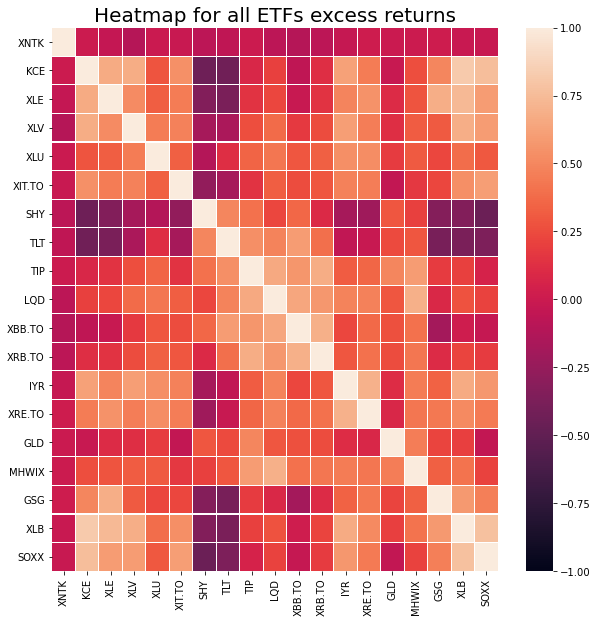

In [9]:
# factors
factors = pd.read_csv(dir + r'\FF_5_Factor.csv', index_col=0)
rf = pd.DataFrame(factors['RF'].iloc[1:], columns=['RF'])  # risk-free rate data
ret_factor = factors.drop('RF', axis=1).iloc[1:]  # factor returns data
rf.set_index(dates, inplace=True)
ret_factor.set_index(dates, inplace=True)

# CAD/USD FX rate
FX = pd.read_csv(dir + r'\USD_CAD_Historical_Data.csv', index_col=0)  # FX rate
FX.set_index(dates, inplace=True)

# Excess Return
exRet_nonESG = ret_nonESG.sub(rf['RF'], 0)  # non ESG ETFs excess return dataset
exRet_ESG = ret_ESG.sub(rf['RF'], 0)

# leverage
init_cap = cap * (1+leverage)  # total initial capital including leverage  # initial capital + leverage
loan = cap * leverage  # loan at start of investment period; interest rate = RFR

# 3. system implementation
exRet_portf = exRet_nonESG.copy()  # portfolio excess return dataset for non ESG ETFs
# separate by asset class
exRet_equity_FI_USD = pd.DataFrame(exRet_portf, columns=tickers_nonESG_equity_FI_USD)
exRet_other_USD = pd.DataFrame(exRet_portf, columns=tickers_nonESG_other_USD)
exRet_equity_FI_CAD = pd.DataFrame(exRet_portf, columns=tickers_nonESG_equity_FI_CAD)
exRet_other_CAD = pd.DataFrame(exRet_portf, columns=tickers_nonESG_other_CAD)

if ESG == 'No':
    price_portf = df_nonESG.iloc[1:].loc[:reportDate].copy()  # investment portfolio's monthly price dataset for non ESG
    # apply FX on USD non ESG ETFs price
    price_portf[tickers_nonESG_equity_FI_USD + tickers_nonESG_other_USD] = \
        price_portf[tickers_nonESG_equity_FI_USD + tickers_nonESG_other_USD].mul(FX['Price'], axis=0)
    price_portf = pd.concat([price_portf[tickers_nonESG_equity_FI_USD], price_portf[tickers_nonESG_other_USD],
                             price_portf[tickers_nonESG_equity_FI_CAD], price_portf[tickers_nonESG_other_CAD]],
                            axis=1).copy()

if ESG == 'Yes':
    price_portf = pd.concat([df_nonESG, df_ESG], axis=1).iloc[1:].loc[:reportDate].copy()  # non ESG+ESG ETFs price data
    exRet_portf = pd.concat([exRet_nonESG, exRet_ESG], axis=1).copy()  # non ESG+ESG ETFs excess return data
    # ESG ETFs returns
    exRet_ESG_equity_FI_USD = pd.DataFrame(exRet_portf, columns=tickers_ESG_equity_USD)
    # apply FX on USD ETFs for both non ESG and ESG
    price_portf[tickers_nonESG_equity_FI_USD + tickers_nonESG_other_USD + tickers_ESG_equity_USD] = \
        price_portf[tickers_nonESG_equity_FI_USD + tickers_nonESG_other_USD + tickers_ESG_equity_USD].mul(FX['Price'],
                                                                                                          axis=0)
    price_portf = pd.concat([price_portf[tickers_nonESG_equity_FI_USD], price_portf[tickers_nonESG_other_USD],
                             price_portf[tickers_nonESG_equity_FI_CAD], price_portf[tickers_nonESG_other_CAD],
                             price_portf[tickers_ESG_equity_USD]],
                            axis=1).copy()


n = exRet_portf.shape[1]  # number of ETFs in the portfolio
n_equity_FI_USD = exRet_equity_FI_USD.shape[1]  # number of USD ETFs (equity+FI)
n_other_USD = exRet_other_USD.shape[1]  # number of USD ETFs (equity+FI)
n_equity_FI_CAD = exRet_equity_FI_CAD.shape[1]  # number of CAD ETFs (equity+FI)
n_other_CAD = exRet_other_CAD.shape[1]  # number of CAD ETFs (equity+FI)
n_ESG_equity_FI_USD = exRet_ESG_equity_FI_USD.shape[1]  # number of ESG USD ETFs (equity+FI)
testStart = exRet_portf.loc[startDate:].index[0]  # each rebalancing period start date
testEnd = exRet_portf.loc[startDate:].index[6] - timedelta(days=1)   # each rebalancing period end date
caliEnd = testStart - timedelta(days=1)  # the end of each calibration period
NoPeriods = math.ceil((len(exRet_portf.loc[startDate:]) - 1) / rebalFreq)  # number of rebalancing periods
testMonths = len(exRet_portf.loc[startDate:])  # number of months in the test period
testDate = exRet_portf.loc[startDate:].index  # all dates in the test period


# Preallocate space
x_equity_FI_USD = np.zeros((n_equity_FI_USD, NoPeriods))  # USD equity + FI non ESG ETFs weight
x_other_USD = np.zeros((n_other_USD, NoPeriods))  # USD REIT + commodity non ESG ETFs weight
x_equity_FI_CAD = np.zeros((n_equity_FI_CAD, NoPeriods))  # CAD equity + FI non ESG ETFs weight
x_other_CAD = np.zeros((n_other_CAD, NoPeriods))  # CAD REIT + commodity non ESG ETFs weight
x_ESG_equity_FI_USD = np.zeros((n_ESG_equity_FI_USD, NoPeriods))  # USD ESG equity ETFs weight
x = np.zeros((n, NoPeriods))  # all ETFs weights
x0 = np.zeros((n, NoPeriods))  # all ETFs weights before rebalancing
adj_R2_bar = np.zeros(NoPeriods)
NoShares = np.zeros(n)  # all ETFs number of shares before rebalancing
NoShares_new = np.zeros(n)  # all ETFs number of shares after rebalancing
currentVal = np.zeros(NoPeriods)  # last observed portfolio value during current calibration period
portfValue = np.zeros(testMonths)  # portfolio value for each month in the test period
turnover = np.zeros(NoPeriods)
testDate2 = np.zeros(NoPeriods, dtype='datetime64[ns]')  # last day during each rebalancing period

# loop through each rebalancing period
for t in range(NoPeriods):
    # excess return of portfolio for the calibration period
    ret_cali_equity_FI_USD = exRet_equity_FI_USD.loc[caliEnd-timedelta(days=caliYr*365.25):caliEnd]
    ret_cali_other_USD = exRet_other_USD.loc[caliEnd - timedelta(days=caliYr * 365.25):caliEnd]
    ret_cali_equity_FI_CAD = exRet_equity_FI_CAD.loc[caliEnd-timedelta(days=caliYr*365.25):caliEnd]
    ret_cali_other_CAD = exRet_other_CAD.loc[caliEnd - timedelta(days=caliYr * 365.25):caliEnd]
    if ESG == 'Yes':
        ret_cali_ESG_equity_FI_USD = exRet_ESG_equity_FI_USD.loc[caliEnd - timedelta(days=caliYr * 365.25):caliEnd]

    # factors return for the calibration period
    ret_factor_cali = ret_factor.loc[caliEnd-timedelta(days=caliYr*365.25):caliEnd]

    currPrice = price_portf.loc[:caliEnd].iloc[-1]  # last observed price during calibration period
    testPrice = price_portf.loc[testStart:testEnd]  # rebalancing period prices
    testPeriod = len(price_portf.loc[testStart:testEnd])
    testDate2[t] = price_portf.loc[testStart:testEnd].index[-1].value  # last day during each rebalancing period

    if t == 0:
        # last observed portfolio value during current calibration period
        currentVal[t] = init_cap
    else:
        currentVal[t] = np.dot(currPrice, NoShares) + injection - trans_cost

        # store the current asset weights (before rebalance)
        x0[:, t] = (currPrice * NoShares) / currentVal[t]

    # portfolio construction
    # factor model: OLS calibration + optimization model, apply on each asset class
    # Risk-Parity
    if allocation_model == 'RP':
        if ESG == 'No':
            mu1, Q1, adj_R2_bar1 = OLS(ret_cali_equity_FI_USD, ret_factor_cali)
            x_equity_FI_USD[:, t] = RP(Q1) * countryPerc * equityFI_perc

            mu2, Q2, adj_R2_bar2 = OLS(ret_cali_other_USD, ret_factor_cali)
            x_other_USD[:, t] = RP(Q2) * countryPerc * (1-equityFI_perc)

            mu3, Q3, adj_R2_bar3 = OLS(ret_cali_equity_FI_CAD, ret_factor_cali)
            x_equity_FI_CAD[:, t] = RP(Q3) * countryPerc * equityFI_perc

            mu4, Q4, adj_R2_bar4 = OLS(ret_cali_other_CAD, ret_factor_cali)
            x_other_CAD[:, t] = RP(Q4) * countryPerc * (1-equityFI_perc)

        elif ESG == 'Yes':
            mu1, Q1, adj_R2_bar1 = OLS(ret_cali_equity_FI_USD, ret_factor_cali)
            x_equity_FI_USD[:, t] = RP(Q1) * (countryPerc * equityFI_perc - ESGperc)  # 20%

            mu2, Q2, adj_R2_bar2 = OLS(ret_cali_other_USD, ret_factor_cali)
            x_other_USD[:, t] = RP(Q2) * countryPerc * (1 - equityFI_perc)  # 10%

            mu3, Q3, adj_R2_bar3 = OLS(ret_cali_equity_FI_CAD, ret_factor_cali)
            x_equity_FI_CAD[:, t] = RP(Q3) * countryPerc * equityFI_perc  # 40%

            mu4, Q4, adj_R2_bar4 = OLS(ret_cali_other_CAD, ret_factor_cali)
            x_other_CAD[:, t] = RP(Q4) * countryPerc * (1 - equityFI_perc)  # 10%

            mu5, Q5, adj_R2_bar5 = OLS(ret_cali_ESG_equity_FI_USD, ret_factor_cali)
            x_ESG_equity_FI_USD[:, t] = RP(Q5) * ESGperc  # 20%
    # CVaR
    elif allocation_model == 'CVaR':
        if ESG == 'No':
            mu1, Q1, adj_R2_bar1 = OLS(ret_cali_equity_FI_USD, ret_factor_cali)
            x_equity_FI_USD[:, t] = CVaR(ret_cali_equity_FI_USD, alpha) * countryPerc * equityFI_perc

            mu2, Q2, adj_R2_bar2 = OLS(ret_cali_other_USD, ret_factor_cali)
            x_other_USD[:, t] = CVaR(ret_cali_other_USD, alpha) * countryPerc * (1 - equityFI_perc)

            mu3, Q3, adj_R2_bar3 = OLS(ret_cali_equity_FI_CAD, ret_factor_cali)
            x_equity_FI_CAD[:, t] = CVaR(ret_cali_equity_FI_CAD, alpha) * countryPerc * equityFI_perc

            mu4, Q4, adj_R2_bar4 = OLS(ret_cali_other_CAD, ret_factor_cali)
            x_other_CAD[:, t] = CVaR(ret_cali_other_CAD, alpha) * countryPerc * (1 - equityFI_perc)

        elif ESG == 'Yes':
            mu1, Q1, adj_R2_bar1 = OLS(ret_cali_equity_FI_USD, ret_factor_cali)
            x_equity_FI_USD[:, t] = CVaR(ret_cali_equity_FI_USD, alpha) * (countryPerc * equityFI_perc - ESGperc)  # 20%

            mu2, Q2, adj_R2_bar2 = OLS(ret_cali_other_USD, ret_factor_cali)
            x_other_USD[:, t] = CVaR(ret_cali_other_USD, alpha) * countryPerc * (1 - equityFI_perc)  # 10%

            mu3, Q3, adj_R2_bar3 = OLS(ret_cali_equity_FI_CAD, ret_factor_cali)
            x_equity_FI_CAD[:, t] = CVaR(ret_cali_equity_FI_CAD, alpha) * countryPerc * equityFI_perc  # 40%

            mu4, Q4, adj_R2_bar4 = OLS(ret_cali_other_CAD, ret_factor_cali)
            x_other_CAD[:, t] = CVaR(ret_cali_other_CAD, alpha) * countryPerc * (1 - equityFI_perc)  # 10%

            mu5, Q5, adj_R2_bar5 = OLS(ret_cali_ESG_equity_FI_USD, ret_factor_cali)
            x_ESG_equity_FI_USD[:, t] = CVaR(ret_cali_ESG_equity_FI_USD, alpha) * ESGperc  # 20%
    # Robust MVO
    elif allocation_model == 'robustMVO':
        if ESG == 'No':
            mu1, Q1, adj_R2_bar1 = OLS(ret_cali_equity_FI_USD, ret_factor_cali)
            x_equity_FI_USD[:, t] = robustMVO(mu1, Q1, riskAver, alpha) * countryPerc * equityFI_perc

            mu2, Q2, adj_R2_bar2 = OLS(ret_cali_other_USD, ret_factor_cali)
            x_other_USD[:, t] = robustMVO(mu2, Q2, riskAver, alpha) * countryPerc * (1 - equityFI_perc)

            mu3, Q3, adj_R2_bar3 = OLS(ret_cali_equity_FI_CAD, ret_factor_cali)
            x_equity_FI_CAD[:, t] = robustMVO(mu3, Q3, riskAver, alpha) * countryPerc * equityFI_perc

            mu4, Q4, adj_R2_bar4 = OLS(ret_cali_other_CAD, ret_factor_cali)
            x_other_CAD[:, t] = robustMVO(mu4, Q4, riskAver, alpha) * countryPerc * (1 - equityFI_perc)

        elif ESG == 'Yes':
            mu1, Q1, adj_R2_bar1 = OLS(ret_cali_equity_FI_USD, ret_factor_cali)
            x_equity_FI_USD[:, t] = robustMVO(mu1, Q1, riskAver, alpha) * (countryPerc * equityFI_perc - ESGperc)

            mu2, Q2, adj_R2_bar2 = OLS(ret_cali_other_USD, ret_factor_cali)
            x_other_USD[:, t] = robustMVO(mu2, Q2, riskAver, alpha) * countryPerc * (1 - equityFI_perc)

            mu3, Q3, adj_R2_bar3 = OLS(ret_cali_equity_FI_CAD, ret_factor_cali)
            x_equity_FI_CAD[:, t] = robustMVO(mu3, Q3, riskAver, alpha) * countryPerc * equityFI_perc

            mu4, Q4, adj_R2_bar4 = OLS(ret_cali_other_CAD, ret_factor_cali)
            x_other_CAD[:, t] = robustMVO(mu4, Q4, riskAver, alpha) * countryPerc * (1 - equityFI_perc)

            mu5, Q5, adj_R2_bar5 = OLS(ret_cali_ESG_equity_FI_USD, ret_factor_cali)
            x_ESG_equity_FI_USD[:, t] = robustMVO(mu5, Q5, riskAver, alpha) * ESGperc
    # adjusted R-square: check model fitting
    if ESG == 'No':
        adj_R2_bar[t] = (adj_R2_bar1 + adj_R2_bar2 + adj_R2_bar3 + adj_R2_bar4) / 4
        # new asset weight
        x[:, t] = np.append(np.append(np.append(x_equity_FI_USD[:, t], x_other_USD[:, t]), x_equity_FI_CAD[:, t]),
                            x_other_CAD[:, t])
        tickers = tickers_nonESG_equity_FI_USD + tickers_nonESG_other_USD + tickers_nonESG_equity_FI_CAD + \
                  tickers_nonESG_other_CAD
        # weight dataframe
        weights = pd.DataFrame(x.T, columns=tickers)
    elif ESG == 'Yes':
        adj_R2_bar[t] = (adj_R2_bar1 + adj_R2_bar2 + adj_R2_bar3 + adj_R2_bar4 + adj_R2_bar5) / 5
        x[:, t] = np.append(np.append(np.append(np.append(x_equity_FI_USD[:, t], x_other_USD[:, t]),
                                                x_equity_FI_CAD[:, t]), x_other_CAD[:, t]), x_ESG_equity_FI_USD[:, t])
        tickers = tickers_nonESG_equity_FI_USD + tickers_nonESG_other_USD + tickers_nonESG_equity_FI_CAD + \
                  tickers_nonESG_other_CAD + tickers_ESG_equity_USD
        weights = pd.DataFrame(x.T, columns=tickers)

    NoShares_new = x[:, t] * currentVal[t] / currPrice  # Number of shares to be allocated to each ETFs
    trans_cost = sum(abs(NoShares_new - NoShares) * cost)
    NoShares = NoShares_new

    # calculate the  portfolio value at each month during the test period
    for j in range(testPeriod):
        index_portf = np.where(exRet_portf.loc[startDate:].index == testStart)[0][0]
        # loan interest accumulation
        rf_7yr = 1.56  # used 7-year treasury rate from 2016-04-01 which is 1.56%
        loan_pay = loan * (1 + rf_7yr / 100) ** ((index_portf+j)/12)  # accumulated by 7-year treasury rate

        if j == 0:
            price_portf.loc[testStart]
            portfValue[index_portf+j] = np.dot(testPrice, NoShares_new)[j] - loan_pay - trans_cost
        else:
            portfValue[index_portf+j] = np.dot(testPrice, NoShares_new)[j] - loan_pay

    # calculate the turnover rate
    if t > 0:
        turnover[t] = sum(abs(x[:, t] - x0[:, t]))

    # Update the calibration and out-of-sample test periods
    if t < 9:
        testStart = exRet_portf.loc[testStart:].index[6]  # each rebalancing period start date
        testEnd = exRet_portf.loc[testStart:].index[6] - timedelta(days=1)  # each rebalancing period end date
        caliEnd = testStart - timedelta(days=1)  # the end of each calibration period
    elif t == 9:
        testStart = exRet_portf.loc[testStart:].index[6]  # each rebalancing period start date
        testEnd = exRet_portf.loc[testStart:].index[-1]  # each rebalancing period end date
        caliEnd = testStart - timedelta(days=1)  # the end of each calibration period


# outputs:
print('portfolio value evolution:' + str(portfValue.T))
print(weights)  # portfolio weighting
# print('portfolio weighting:' + str(x.T))
print('turnover:' + str(turnover))
print('adjusted R-squared:' + str(adj_R2_bar))
print('date:' + str(testDate))

# Check the correlation heatmap for our dataset
fig, ax = plt.subplots(figsize=(10,10))
corr = exRet_portf.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, linewidths=.1, vmin=-1, vmax=1)
ax.set_title('Heatmap for all ETFs excess returns', fontsize=20)
plt.show()


In [10]:
# remove injection from cashflow
portfValue_wocf = portfValue.copy()
portfPnL_wocf = np.diff(portfValue_wocf)
for i in range(len(portfPnL_wocf)):
    if i%injectFreq==injectFreq-1:
        portfPnL_wocf[i] = portfPnL_wocf[i] - injection
portfRet_wocf = portfPnL_wocf/portfValue_wocf[:-1]

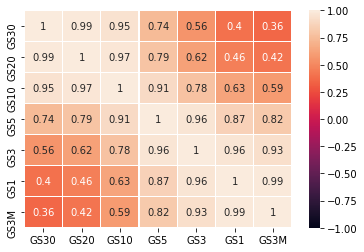

In [11]:
# --------------------sensitivity analysis-------------------
# handling df_macro
df_macro = pd.read_excel(dir + r'\Macro_Data.xlsx', sheet_name='Index', index_col=0, engine='openpyxl')
df_macro = df_macro.drop(['AAA', 'BAA'], axis=1)
# df_macro['USACPIALLMINMEI'] = df_macro['USACPIALLMINMEI'].pct_change() * 100
# df_macro['INDPRO'] = df_macro['INDPRO'].pct_change() * 100
# df_macro[['MCOILWTICO', 'HOUST']] = df_macro[['MCOILWTICO', 'HOUST']].pct_change() * 100
df_macro[['INDPRO', 'USACPIALLMINMEI', 'CBS', 'T10Y3MM', 'MCOILWTICO', 'HOUST', 'UNRATE']] = df_macro[['INDPRO', 'USACPIALLMINMEI', 'CBS', 'T10Y3MM', 'MCOILWTICO', 'HOUST', 'UNRATE']].pct_change() * 100

macro_corr = df_macro[['GS30', 'GS20', 'GS10', 'GS5', 'GS3', 'GS1', 'GS3M']].corr()
sns.heatmap(macro_corr, xticklabels=macro_corr.columns, yticklabels=macro_corr.columns, annot=True,linewidths=.1, vmin=-1, vmax=1)
ax.set_title('Heatmap for the yield curve', fontsize=20)
plt.show()

# PCA the yield curve
yieldcurve = df_macro[['GS30', 'GS20', 'GS10', 'GS5', 'GS3', 'GS1', 'GS3M']]
yieldcurve = StandardScaler().fit_transform(yieldcurve)
pca = PCA(n_components=1)
principalComponents = pca.fit_transform(yieldcurve)
principalDf = pd.DataFrame(data=principalComponents, columns=['principal component'])
df_macro['Yield Curve PCA'] = principalDf.values
df_macro = df_macro.drop(['GS30', 'GS20', 'GS10', 'GS5', 'GS3', 'GS1', 'GS3M'], axis=1)
# df_macro['Yield Curve PCA']=df_macro['Yield Curve PCA'].pct_change() * 100
df_macro=df_macro.iloc[1:]


In [12]:
# We tried different combinations of the economic factors for the regression with market factors
# and checked the stats like R-adjusted square and P-values for each factor. Finally, we decided to choose the
# following economic factors for the stress testing model.

# We tried standard scaler to normalize the macro dataframe,
# however the performance is not improving.

# We use backward elimination approach, where all variables are initially included, 
# and in each step, the most statistically insignificant variable is dropped until the R adjusted square stop increasing

In [13]:
df_macro_new = df_macro[['USACPIALLMINMEI', 'CBS', 'T10Y3MM', 'MCOILWTICO', 'HOUST',
       'UNRATE', 'Yield Curve PCA']]

In [14]:
# sensitivity analysis for the allocation model
portfRet_up=np.zeros((len(df_macro_new.columns),len(df_macro_new.columns)+2))
portfRet_down=np.zeros((len(df_macro_new.columns),len(df_macro_new.columns)+2))
portfRet_wocf = pd.DataFrame(portfRet_wocf,index=testDate[1:],columns=['portfValue'])

# macro data for the test period
df_macro_test = df_macro_new.loc[portfRet_wocf.index]
# fit model for x=macro factor returns, y=portofolio return during the test period
df_macro_test = sm.add_constant(df_macro_test)
model = sm.OLS(portfRet_wocf, df_macro_test).fit()


In [15]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             portfValue   R-squared:                       0.454
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     6.426
Date:                Mon, 19 Jul 2021   Prob (F-statistic):           1.62e-05
Time:                        16:31:27   Log-Likelihood:                 144.73
No. Observations:                  62   AIC:                            -273.5
Df Residuals:                      54   BIC:                            -256.4
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0113      0.004      2.657      0.010       0.003       0.020
USACPIALLMINMEI    -0.0055      0.014     -0.395      0.694      -0.033       0.022
CBS                -0.0006      0.001     -0.948      0.347      -0.002       0.001
T10Y3MM          3.508e-05   2.33e-05      1.506      0.138   -1.16e-05    8.18e-05
MCOILWTICO          0.0003      0.000      0.779      0.439      -0.000       0.001
HOUST               0.0004      0.000      1.033      0.306      -0.000       0.001
UNRATE              0.0007      0.000      4.593      0.000       0.000       0.001
Yield Curve PCA     0.0004      0.002      0.197      0.845      -0.004       0.004
==============================================================================
Omnibus:                        5.990   Durbin-Watson:                   2.406
Prob(Omnibus):                  0.050   Jarque-Bera (JB):                5.741
Skew:                           0.465   Prob(JB):                       0.0567
Kurtosis:                       4.165   Cond. No.                         975.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
# different scenarios for the macro factor return

# normal scenario
norm_scenario = df_macro_test.median()
portfRet_norm = np.dot(np.array(norm_scenario), np.array(model.params))
print('For the normal scenario, the monthly portfolio return is {}'.format(portfRet_norm))

# up scenario for each macro factor - shocking factor return one by one
for i in range(norm_scenario.shape[0]):
    if i != 0:
        norm_scenario_up = norm_scenario.copy()
        macro_fact = norm_scenario_up.index[i]
        norm_scenario_up[macro_fact]=norm_scenario_up[macro_fact]*2
        portfRet_up[i-1,:-1] = norm_scenario_up
        portfRet_up[i-1,-1] = np.dot(np.array(norm_scenario_up), np.array(model.params))
portfRet_up_df = pd.DataFrame(portfRet_up,columns = norm_scenario.index.to_list() + ['Monthly Return'])
portfRet_up_df['AllocationModel'] = allocation_model

# down scenario for each macro factor
for i in range(norm_scenario.shape[0]):
    if i != 0:
        norm_scenario_down = norm_scenario.copy()
        macro_fact = norm_scenario_down.index[i]
        norm_scenario_down[macro_fact]=norm_scenario_down[macro_fact]*0.5
        portfRet_down[i-1,:-1] = norm_scenario_down
        portfRet_down[i-1,-1] = np.dot(np.array(norm_scenario_down), np.array(model.params))
portfRet_down_df = pd.DataFrame(portfRet_down,columns = norm_scenario.index.to_list() + ['Monthly Return'])
portfRet_down_df['AllocationModel'] = allocation_model

# Method2: use copula to simulate macro factor returns
copula = VineCopula('regular')
copula.fit(df_macro_test.drop(['const'],axis=1))
samples = copula.sample(1000)
samples.insert(0, 'constant', 1)
# Use the simulated factor returns to generate portfolio return using fitted OLS parameters
samplePortfolio = np.dot(np.array(samples), np.array(model.params))
samples['Portfolio Estimated Return'] = samplePortfolio
# best 3 up scenario and the best 3 down scenario for the simulated factor returns
upScenario1 = samples.sort_values('Portfolio Estimated Return', ascending=0).iloc[:3, :]
downScenario1 = samples.sort_values('Portfolio Estimated Return', ascending=1).iloc[:3, :]
upScenario1['AllocationModel'] = allocation_model
downScenario1['AllocationModel'] = allocation_model

print('the best 3 up scenario: {}'.format(upScenario1))
print('the best 3 down scenario: {}'.format(downScenario1))

For the normal scenario, the monthly portfolio return is 0.011541139858135246


D:\Anaconda\lib\site-packages\copulas\multivariate\vine.py:68: UserWarning: Vines have not been fully tested on Python 3.8 and might produce wrong results. Please use Python 3.5, 3.6 or 3.7
  warnings.warn(
D:\Anaconda\lib\site-packages\copulas\bivariate\base.py:160: RuntimeWarning: Data does not appear to be uniform.
  warnings.warn("Data does not appear to be uniform.", category=RuntimeWarning)


the best 3 up scenario:      constant  USACPIALLMINMEI        CBS     T10Y3MM  MCOILWTICO      HOUST  \
780         1         0.794625  -0.214071  627.931361   70.249061  24.912360   
962         1         0.786541  13.158576  -84.528136   70.614063  24.734916   
814         1         0.798898   7.736654 -188.790492   70.614063  22.337989   

         UNRATE  Yield Curve PCA  Portfolio Estimated Return AllocationModel  
780  219.981687         3.097971                    0.216485            CVaR  
962  222.305934         2.530946                    0.184384            CVaR  
814  222.007985         1.833301                    0.182597            CVaR  
the best 3 down scenario:      constant  USACPIALLMINMEI        CBS      T10Y3MM  MCOILWTICO      HOUST  \
507         1        -0.966031 -21.209325 -1758.597328   -7.579047 -28.137025   
279         1        -0.764394 -18.456503 -1569.551826  -50.071514 -19.847847   
993         1        -0.617830 -22.130864 -1396.059491  -47.194971 -23

In [17]:
# formatting the 'sensitivity.xlsx' output file
if allocation_model == 'RP':
    arow=1
elif allocation_model == 'robustMVO':
    arow=10
elif allocation_model == 'CVaR':
    arow=20

# Export results to excel
from openpyxl import load_workbook
pd.read_excel(dir + r'\ESG_Prices.xlsx', sheet_name='Prices', index_col=0, engine='openpyxl')
book = load_workbook(dir + r'\sensitivity.xlsx')
writer = pd.ExcelWriter(dir + r'\sensitivity.xlsx', engine='openpyxl') 
writer.book = book

## ExcelWriter for some reason uses writer.sheets to access the sheet.
## If you leave it empty it will not know that sheet Main is already there
## and will create a new sheet.

writer.sheets = dict((ws.title, ws) for ws in book.worksheets)

portfRet_up_df.to_excel(writer,
                        sheet_name='portfRet_up_df',startrow=arow)
portfRet_down_df.to_excel(writer,
                          sheet_name='portfRet_down_df',startrow=arow)
upScenario1.to_excel(writer,
                     sheet_name='upScenario',startrow=arow)
downScenario1.to_excel(writer,
                       sheet_name='downScenario',startrow=arow)

writer.save()
writer.close()

In [18]:
def VaRCalc(returns):
    # VaR and CVaR Calculation
    
    period = 1. # horizon of 1 day
    mu_p = np.mean(returns)/30
    sig_p = np.std(returns)*np.sqrt(period/30)
    alpha = 0.01

    VaR_1 = norm.ppf(1-alpha)*sig_p - mu_p 
    value_1 =portfValue_wocf[-1]*VaR_1
    print("99% 1 day VaR :", round(VaR_1*100,2),"% or", round(value_1),"$")

    CVaR_1 = alpha**-1 * norm.pdf(norm.ppf(alpha))*sig_p - mu_p
    value_C_1 =portfValue_wocf[-1]*CVaR_1
    print("99% 1 day CVaR/ES :", round(CVaR_1*100,2),"% or", round(value_C_1),"$")

    period = 10. # horizon of 10 days
    mu_p = np.mean(returns)/30*period
    sig_p = np.std(returns) * np.sqrt(period/30)
    VaR_2 = norm.ppf(1-alpha)*sig_p - mu_p
    value_2=portfValue_wocf[-1]*VaR_2
    print("99% 10 day VaR :", round(VaR_2*100,2),"% or", round(value_2),"$")

    CVaR_2 = alpha**-1 * norm.pdf(norm.ppf(alpha))*sig_p - mu_p
    value_C_2 =portfValue_wocf[-1]*CVaR_2
    print("99% 10 day CVaR/ES :", round(CVaR_2*100,2),"% or", round(value_C_2),"$")
    
    return VaR_1, value_1, CVaR_1, value_C_1, VaR_2, value_2, CVaR_2, value_C_2 

In [19]:
# Scenario Analysis - Stress VaR
# factors
factors_all = pd.read_csv(dir + r'\FF_5_Factor_all.csv', index_col=0,parse_dates=True)
ret_factor_all = factors_all[['Mkt-RF','SMB','HML','RMW','CMA']].iloc[:-1,:]
ret_factor_test = ret_factor_all.loc[exRet_portf.index] # exRet_portf.index is from 2007-02-01 to 2016-03-01

# historical asset returns
data_all = pd.read_excel(dir + r'\Historical_Data.xlsx', sheet_name='Sheet1', index_col=0,engine='openpyxl')
data_all = data_all.pct_change()

# Calibrate OLS model on the current dataset: X=famma french 5 factor returns, y=asset excess return
scenario_coef = pd.DataFrame(columns=weights.columns)
exRet_portf_test = exRet_portf.copy()
ret_factor_test = sm.add_constant(ret_factor_test)

for tickerindex in range(len(exRet_portf_test.columns)):
    ticker = exRet_portf_test.columns[tickerindex]
    scenario_model = sm.OLS(exRet_portf_test[ticker], ret_factor_test).fit()
    scenario_coef[ticker] = scenario_model.params

# use the results from calibrated OLS model to simulate historical asset returns
ret_factor_all = sm.add_constant(ret_factor_all)
regressed = np.dot(ret_factor_all,scenario_coef)
regressed = pd.DataFrame(regressed,columns = exRet_portf.columns, index=ret_factor_all.index)

# trim data_all with only useful ticker left
data_all = data_all[exRet_portf_test.columns]

# if historical dataset is empty, replace it with the simulated past asset return
for i in range(data_all.shape[0]): #iterate over rows
    for j in range(data_all.shape[1]): #iterate over columns
        adate = data_all.index[i]
        aticker = data_all.columns[j]
        if pd.isna(data_all.iloc[i, j]):
            data_all.loc[adate,aticker] = regressed.loc[adate,aticker]

# list of historical scenarios
# using the weights during the initial test period

# all historical data are simulated so it's not very reliable. skip it
# factors_AsianCrisis = ret_factor_all.loc['1998-04-01':'1998-10-01']
# AsianCrisis = np.dot(np.dot(factors_AsianCrisis,scenario_coef),weights.iloc[0])
# print('For {}:'.format('AsianCrisis'))
# VaRCalc(AsianCrisis)

# this extra weights[data_all.columns] is to align the column of data_all and weights.
techBubble = np.dot(data_all.loc['2000-03-01':'2002-09-01'],weights[data_all.columns].iloc[-1])
print('For {}:'.format('techBubble'))
VaRCalc(techBubble)

sellOff911 = np.dot(data_all.loc['2001-07-01':'2001-09-01'],weights[data_all.columns].iloc[-1])
print('For {}:'.format('sellOff911'))
VaRCalc(sellOff911)

subprimeRecession = np.dot(data_all.loc['2008-01-01':'2009-06-01'],weights[data_all.columns].iloc[-1])
print('For {}:'.format('subprimeRecession'))
VaRCalc(subprimeRecession)

Summer2011 = np.dot(data_all.loc['2011-06-01':'2011-10-01'],weights[data_all.columns].iloc[-1])
print('For {}:'.format('Summer2011'))
VaRCalc(Summer2011)

For techBubble:
99% 1 day VaR : 1.4 % or 4758 $
99% 1 day CVaR/ES : 1.6 % or 5442 $
99% 10 day VaR : 4.56 % or 15480 $
99% 10 day CVaR/ES : 5.19 % or 17642 $
For sellOff911:
99% 1 day VaR : 1.33 % or 4519 $
99% 1 day CVaR/ES : 1.51 % or 5121 $
99% 10 day VaR : 4.98 % or 16911 $
99% 10 day CVaR/ES : 5.54 % or 18816 $
For subprimeRecession:
99% 1 day VaR : 1.98 % or 6740 $
99% 1 day CVaR/ES : 2.27 % or 7710 $
99% 10 day VaR : 6.44 % or 21883 $
99% 10 day CVaR/ES : 7.34 % or 24949 $
For Summer2011:
99% 1 day VaR : 1.3 % or 4427 $
99% 1 day CVaR/ES : 1.49 % or 5064 $
99% 10 day VaR : 4.24 % or 14392 $
99% 10 day CVaR/ES : 4.83 % or 16405 $


(0.013028756916269828,
 4427.047595138866,
 0.014901986830073793,
 5063.553290835145,
 0.04235520214702368,
 14391.894561517844,
 0.0482788752558051,
 16404.702303588118)

In [20]:
# Link to the benchmark data
df_bm = pd.read_excel(dir + r'\Benchmark.xlsx', sheet_name='Prices', index_col=0,engine='openpyxl')
df_bm_val = df_bm.loc[testDate[0:]].copy()
df_bm = df_bm.pct_change()
df_bm = df_bm.loc[testDate[1:]]
# Prepare the risk free data
rf = rf.loc[testDate[1:]]

In [21]:
# calculate the weight of each asset class for benchmark indices
# benchmark strategy: use the initial weight, buy and hold
x_equity = np.sum(x_equity_FI_USD[:5,0])+np.sum(x_equity_FI_CAD[0,0])+np.sum(x_ESG_equity_FI_USD[:,0])
x_fi = np.sum(x_equity_FI_USD[5:,0])+np.sum(x_equity_FI_CAD[1:,0])
x_REIT = np.sum(x_other_USD[0,0])+np.sum(x_other_CAD[:,0])
x_Commodity = np.sum(x_other_USD[1:,0])
ini_weight = [x_equity,x_fi,x_REIT,x_Commodity]
weighted_total_return = []
weighted_total_val = []
for i in range(df_bm.shape[0]):
    total = np.dot(df_bm.values.tolist()[i],ini_weight)
    weighted_total_return.append(total)
df_bm["Weighted Total Return"] = weighted_total_return

for i in range(df_bm_val.shape[0]):
    total_val = np.dot(df_bm_val.values.tolist()[i],ini_weight)
    weighted_total_val.append(total_val)
df_bm_val["Weighted Total Value"] = weighted_total_val

In [22]:
df_bm["Weighted Total Return"]

2016-05-01    0.012094
2016-06-01    0.011870
2016-07-01    0.023988
2016-08-01   -0.003525
2016-09-01    0.000196
                ...   
2021-02-01    0.025239
2021-03-01    0.028884
2021-04-01    0.038815
2021-05-01    0.009824
2021-05-31    0.018201
Name: Weighted Total Return, Length: 62, dtype: float64

In [23]:
# --------------------TESTING ------- sensitivity analysis for benchmark-------------------

In [24]:
# this is all macro factors that we select
df_macro_bm = df_macro[['USACPIALLMINMEI', 'T10Y3MM', 'MCOILWTICO', 
       'UNRATE']]

In [25]:
# sensitivity analysis for the allocation model
bmRet_up=np.zeros((len(df_macro_bm.columns),len(df_macro_bm.columns)+2))
bmRet_down=np.zeros((len(df_macro_bm.columns),len(df_macro_bm.columns)+2))

# macro data for the test period
df_macro_bm = df_macro_bm.loc[df_bm["Weighted Total Return"].index]
# fit model for x=macro data, y=portofolio value during the test period
df_macro_bm = sm.add_constant(df_macro_bm)
model = sm.OLS(df_bm["Weighted Total Return"], df_macro_bm).fit()

In [26]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     Weighted Total Return   R-squared:                       0.294
Model:                               OLS   Adj. R-squared:                  0.245
Method:                    Least Squares   F-statistic:                     5.941
Date:                   Mon, 19 Jul 2021   Prob (F-statistic):           0.000456
Time:                           16:31:39   Log-Likelihood:                 140.37
No. Observations:                     62   AIC:                            -270.7
Df Residuals:                         57   BIC:                            -260.1
Df Model:                              4                                         
Covariance Type:               nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0055      0.004      1.295      0.201      -0.003       0.014
USACPIALLMINMEI     0.0115      0.014      0.823      0.414      -0.016       0.039
T10Y3MM          3.676e-05   1.64e-05      2.238      0.029    3.87e-06    6.97e-05
MCOILWTICO          0.0008      0.000      2.688      0.009       0.000       0.001
UNRATE              0.0004      0.000      2.794      0.007       0.000       0.001
==============================================================================
Omnibus:                        3.263   Durbin-Watson:                   2.400
Prob(Omnibus):                  0.196   Jarque-Bera (JB):                3.117
Skew:                           0.013   Prob(JB):                        0.210
Kurtosis:                       4.098   Cond. No.                         945.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
# --------------------TESTING END-------------------

Portfolio Performance Measure

In [28]:
# Calculate Kurtosis and Skewness
kurtosis = stats.kurtosis(portfRet_wocf)
skewness = stats.skew(portfRet_wocf)
print("Kurtosis:", round(kurtosis[0],5))
print("Skewness:", round(skewness[0],5))

# Export results to excel
import openpyxl
wb = openpyxl.load_workbook(dir + r'\Report.xlsx')
sheet = wb['Report']
sheet['C22'].value = round(kurtosis[0],5)
sheet['C23'].value = round(skewness[0],5)
sheet['C5'].value = startDate.date()
sheet['C6'].value = reportDate.date()

wb.save(dir + r'\Report.xlsx')

Kurtosis: 5.06512
Skewness: 0.56405


In [29]:
# Calculate the Return, Volatility, Correlation with Benchmark, Information Ratio and Sharpe Ratio

TotalReturn = np.prod(1+portfRet_wocf.iloc[:,0])-1 # Total Portfolio Return
annualret=(np.prod(1+portfRet_wocf.iloc[:,0])**(1/len(portfRet_wocf.iloc[:,0]))-1)*12 # Annualized Portfolio Return
annualret_1=(np.prod(1+portfRet_wocf.iloc[-12:,0])**(1/len(portfRet_wocf.iloc[-12:,0]))-1)*12 # 1-yr Annualized Return
annualret_3=(np.prod(1+portfRet_wocf.iloc[-36:,0])**(1/len(portfRet_wocf.iloc[-36:,0]))-1)*12 # 3-yr Annualized Return
annualret_5=(np.prod(1+portfRet_wocf.iloc[-60:,0])**(1/len(portfRet_wocf.iloc[-60:,0]))-1)*12 # 5-yr Annualized Return
stdret= np.std(portfRet_wocf.iloc[:,0], ddof=1)*np.sqrt(12) # Annualized Portfolio Standard Deviation
Corr = np.corrcoef(portfRet_wocf.iloc[:,0], df_bm.iloc[:,-1])[0][1] # Correlation between Portfolio and Weighted Benchmark
Sharpe = (annualret-0.0156)/stdret # Annualized Sharpe Ratio
TotalBenchmarkReturn = np.prod(1+df_bm.iloc[:,-1])-1 # Total Weighted Benchmark Return
annualbret = (np.prod(1+df_bm.iloc[:,-1])**(1/len(df_bm.iloc[:,-1]))-1)*12 # Annualized Benchmark Return
TrackingError = np.std(portfRet_wocf.iloc[:,0]-df_bm.iloc[:,-1])*np.sqrt(12) # Tracking Error
InfoRatio = (annualret-annualbret)/TrackingError # Annualized Information Ratio

print("Annualized Return", round(annualret,2))
print("1-yr Annualized Return", round(annualret_1,2))
print("3-yr Annualized Return", round(annualret_3,2))
print("5-yr Annualized Return", round(annualret_5,2))
print("Annualized Volatility", round(stdret,2))
print("Correlation with Benchmark", round(Corr,2))
print("Tracking Error", round(TrackingError,2))
print("Information Ratio", round(InfoRatio,2))
print("Sharpe Ratio", round(Sharpe,2))

# Export results to excel
wb = openpyxl.load_workbook(dir + r'\Report.xlsx')
sheet = wb['Report']
sheet['C8'].value = round(annualret,4)
sheet['C9'].value = round(annualret_1,4)
sheet['C10'].value = round(annualret_3,4)
sheet['C11'].value = round(annualret_5,4)
sheet['C12'].value = round(stdret,4)
sheet['C17'].value = round(Corr,2)
sheet['C18'].value = round(InfoRatio,4)
sheet['C13'].value = round(Sharpe,4)
sheet['C19'].value = round(TrackingError,2)

wb.save(dir + r'\Report.xlsx')

Annualized Return 0.14
1-yr Annualized Return 0.13
3-yr Annualized Return 0.15
5-yr Annualized Return 0.14
Annualized Volatility 0.11
Correlation with Benchmark 0.75
Tracking Error 0.08
Information Ratio 0.47
Sharpe Ratio 1.12


In [30]:
#Calculate Max Drawdown
import quantstats as qs
max_drawdown=qs.stats.max_drawdown(portfRet_wocf.iloc[:,0])
print("max_drawdown", round(max_drawdown,2))

# Export results to excel
wb = openpyxl.load_workbook(dir + r'\Report.xlsx')
sheet = wb['Report']
sheet['C20'].value = round(max_drawdown,4)

wb.save(dir + r'\Report.xlsx')

max_drawdown -0.12


In [31]:
# Calculate VaR and CVaR
VaR_1, value_1, CVaR_1, value_C_1, VaR_2, value_2, CVaR_2, value_C_2 = VaRCalc(portfRet_wocf.iloc[:,0])

# Export results to excel
wb = openpyxl.load_workbook(dir + r'\Report.xlsx')
sheet = wb['Report']
str(round(annualret,4) * 100) + '%'
sheet['C25'].value = round(VaR_1,4)
sheet['C26'].value = round(CVaR_1,4)
sheet['C27'].value = round(VaR_2,4)
sheet['C28'].value = round(CVaR_2,4)
sheet['D25'].value = round(value_1,2)
sheet['D26'].value = round(value_C_1,2)
sheet['D27'].value = round(value_2,2)
sheet['D28'].value = round(value_C_2,2)

wb.save(dir + r'\Report.xlsx')

99% 1 day VaR : 1.31 % or 4442 $
99% 1 day CVaR/ES : 1.5 % or 5109 $
99% 10 day VaR : 3.86 % or 13104 $
99% 10 day CVaR/ES : 4.48 % or 15213 $


In [32]:
#Measure Beta and alpha
(beta, alpha) = stats.linregress(list(df_bm.iloc[:, -1]), list(portfRet_wocf.iloc[:,0].dropna()))[0:2]
print ("Beta:", round(beta, 2))
print ("Alpha:", round(alpha*12*100, 2))

# Export results to excel
wb = openpyxl.load_workbook(dir + r'\Report.xlsx')
sheet = wb['Report']
sheet['C14'].value = round(alpha*12*100, 2)
sheet['C15'].value = round(beta, 2)

wb.save(dir + r'\Report.xlsx')

Beta: 0.8
Alpha: 5.79


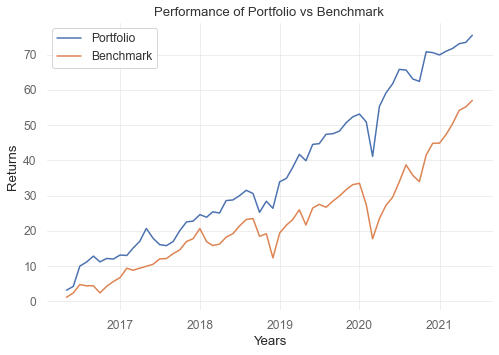

In [33]:
# Plot return of portfolio vs return of benchmark
plt.figure(figsize=(8,5.3))
plt.plot(portfRet_wocf.iloc[:,0].cumsum()*100,label="Portfolio")
plt.plot(df_bm.iloc[:,-1].cumsum()*100,label="Benchmark")
plt.xlabel("Years")
plt.ylabel("Returns")
plt.legend()
plt.title("Performance of Portfolio vs Benchmark")
plt.savefig('return.png')
plt.show()

# Export to Excel
wb = openpyxl.load_workbook(dir + r'\Report.xlsx')
ws = wb['Report']
img = openpyxl.drawing.image.Image(dir + r'\return.png')
img.anchor = 'F31' # Or whatever cell location you want to use.
ws.add_image(img)
wb.save(dir + r'\Report.xlsx')

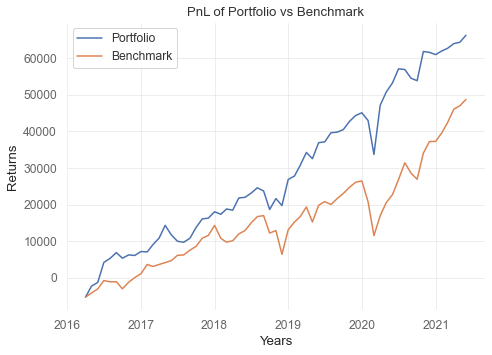

In [34]:
# Plot PnL of portfolio vs PnL of benchmark
pnl_portf = np.append((portfValue_wocf[0] - cap), portfRet_wocf * portfValue_wocf[0]).cumsum()
pnl_bm = np.append((portfValue_wocf[0] - cap), df_bm.iloc[:,-1]*portfValue_wocf[0]).cumsum()
plt.figure(figsize=(7.5,5.3))
plt.plot(testDate, pnl_portf,label="Portfolio")
plt.plot(testDate, pnl_bm,label="Benchmark")
plt.xlabel("Years")
plt.ylabel("Returns")
plt.legend()
plt.title("PnL of Portfolio vs Benchmark")
plt.savefig('PnL.png')
plt.show()

# Export to Excel
wb = openpyxl.load_workbook(dir + r'\Report.xlsx')
ws = wb['Report']
img = openpyxl.drawing.image.Image(dir + r'\PnL.png')
img.anchor = 'B31' # Or whatever cell location you want to use.
ws.add_image(img)
wb.save(dir + r'\Report.xlsx')

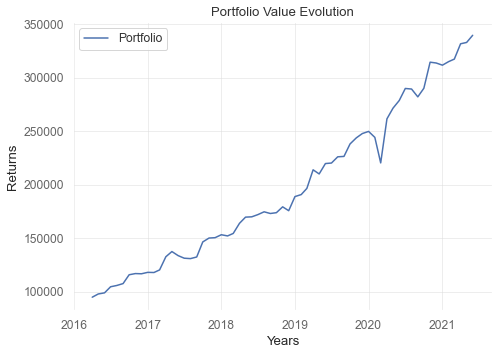

In [35]:
# Portfolio Value Evolution
plt.figure(figsize=(7.5,5.3))
plt.plot(testDate, portfValue,label="Portfolio")
plt.xlabel("Years")
plt.ylabel("Returns")
plt.legend()
plt.title("Portfolio Value Evolution")
plt.savefig('portfvalue.png')
plt.show()

# Export to Excel
wb = openpyxl.load_workbook(dir + r'\Report.xlsx')
ws = wb['Report']
img = openpyxl.drawing.image.Image(dir + r'\portfvalue.png')
img.anchor = 'Q8' # Or whatever cell location you want to use.
ws.add_image(img)
wb.save(dir + r'\Report.xlsx')

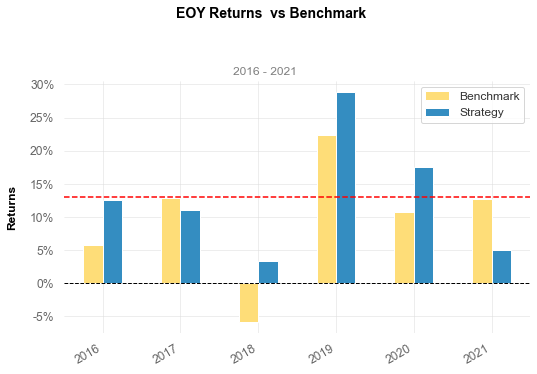

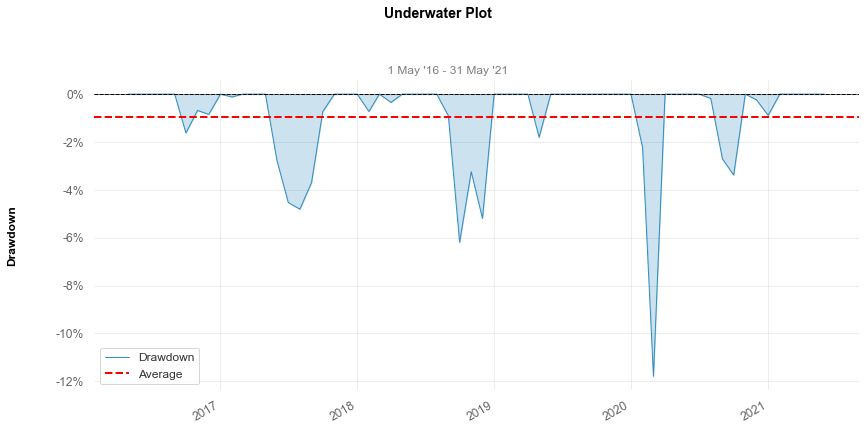

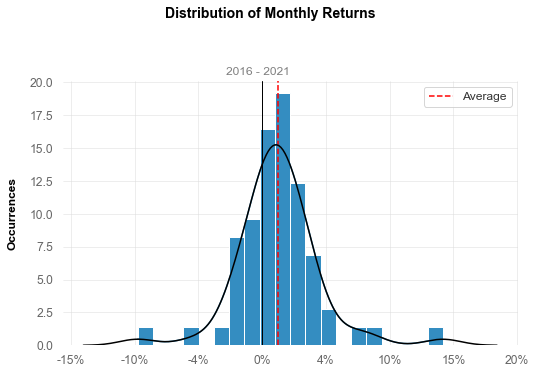

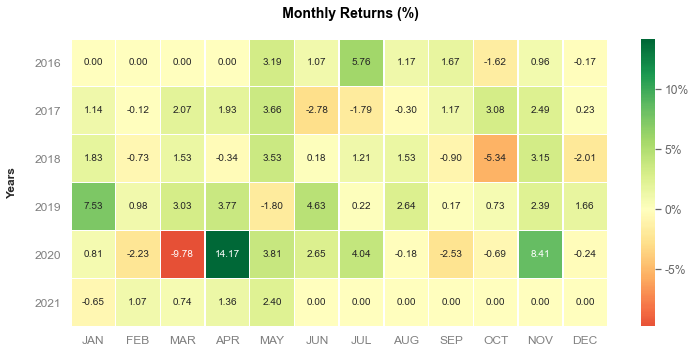

In [36]:
# Use quantstats to plot performance analysis - for reference
qs.plots.yearly_returns(portfRet_wocf.iloc[:, 0],df_bm.iloc[:, -1], figsize=(7.5,5.2),
                        savefig={'fname': dir + r'\EOY_return.png'}) # EOY Returns
qs.plots.drawdown(portfRet_wocf.iloc[:, 0], figsize=(12, 6), savefig={'fname': dir + r'\drawdown.png'})  # drawdowns
qs.plots.histogram(portfRet_wocf.iloc[:, 0], figsize=(7.5,5.2), savefig={'fname': dir + r'\histogram.png'})  # return distribution
qs.plots.monthly_heatmap(portfRet_wocf.iloc[:, 0], figsize=(10, 5), 
                         savefig={'fname': dir + r'\monthly_heatmap.png'})  # monthly return heatmap

# Export to Excel
wb = openpyxl.load_workbook(dir + r'\Report.xlsx')
ws = wb['Report']

img = openpyxl.drawing.image.Image(dir + r'\EOY_return.png')
img.anchor = 'Q27' # Or whatever cell location you want to use.
ws.add_image(img)

img = openpyxl.drawing.image.Image(dir + r'\drawdown.png')
img.anchor = 'S44' # Or whatever cell location you want to use.
ws.add_image(img)

img = openpyxl.drawing.image.Image(dir + r'\histogram.png')
img.anchor = 'Z27' # Or whatever cell location you want to use.
ws.add_image(img)

img = openpyxl.drawing.image.Image(dir + r'\monthly_heatmap.png')
img.anchor = 'C46' # Or whatever cell location you want to use.
ws.add_image(img)

wb.save(dir + r'\Report.xlsx')

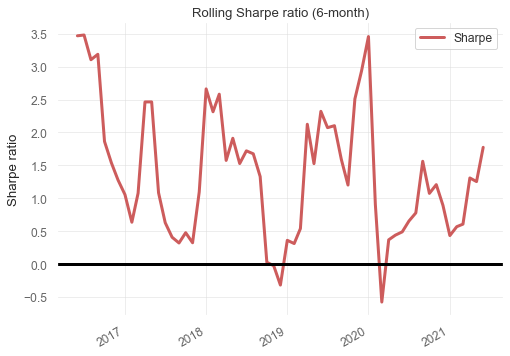

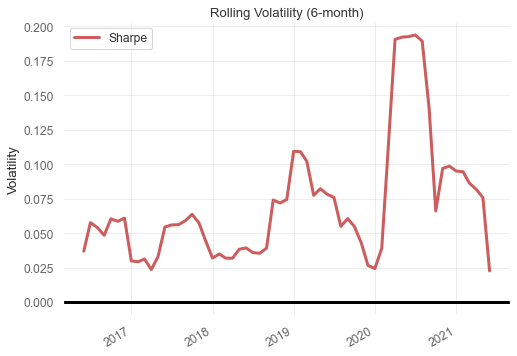

In [37]:
def my_rolling_sharpe(y):
    return np.sqrt(6) * (y.mean() / y.std())

def my_rolling_vol(y):
    return np.sqrt(6) * (y.std())

portfRet_wocf['rs'] = portfRet_wocf['portfValue'].rolling('182d').apply(my_rolling_sharpe)
portfRet_wocf['rv'] = portfRet_wocf['portfValue'].rolling('182d').apply(my_rolling_vol)

# rolling sharpe ratio (6 months)
portfRet_wocf['rs'].iloc[1:].plot(style='-', lw=3, color='indianred', label='Sharpe', figsize=[8,6])\
        .axhline(y = 0, color = "black", lw = 3)
plt.ylabel('Sharpe ratio')
plt.legend(loc='best')
plt.title('Rolling Sharpe ratio (6-month)')
fig.tight_layout()
plt.savefig('rolling_SR.png')
plt.show()

# Export to Excel
wb = openpyxl.load_workbook(dir + r'\Report.xlsx')
ws = wb['Report']
img = openpyxl.drawing.image.Image(dir + r'\rolling_SR.png')
img.anchor = 'AJ46' # Or whatever cell location you want to use.
ws.add_image(img)
wb.save(dir + r'\Report.xlsx')

# rolling volatility (6 months)
portfRet_wocf['rv'].iloc[1:].plot(style='-', lw=3, color='indianred', label='Sharpe', figsize=[8,6])\
        .axhline(y = 0, color = "black", lw = 3)
plt.ylabel('Volatility')
plt.legend(loc='best')
plt.title('Rolling Volatility (6-month)')
fig.tight_layout()
plt.savefig('rolling_vol.png')
plt.show()

# Export to Excel
wb = openpyxl.load_workbook(dir + r'\Report.xlsx')
ws = wb['Report']
img = openpyxl.drawing.image.Image(dir + r'\rolling_vol.png')
img.anchor = 'AR46' # Or whatever cell location you want to use.
ws.add_image(img)
wb.save(dir + r'\Report.xlsx')


In [38]:
# Separate into different classes based on currencies, ESG or Non-ESG, and assets and get the corresponding weights
tickers_nonESG_equity_USD = ['XNTK', 'KCE', 'XLE', 'XLV', 'XLU']
tickers_nonESG_FI_USD = ['SHY', 'TLT', 'TIP', 'LQD', 'MHWIX']
tickers_nonESG_REIT_USD = ['IYR']
tickers_nonESG_Commodity_USD = [ 'GLD', 'GSG']
tickers_nonESG_equity_CAD = ['XIT.TO']
tickers_nonESG_FI_CAD = ['XBB.TO', 'XRB.TO']
tickers_nonESG_REIT_CAD = ['XRE.TO']
tickers_ESG_equity_USD = ['XLB', 'SOXX']

weights_asset_class = pd.DataFrame() # create a new dataframe to store the weight for each asset class
weights_asset_class["nonESG_Equity_USD"] = weights[tickers_nonESG_equity_USD].sum(axis=1)
weights_asset_class["nonESG_FI_USD"] = weights[tickers_nonESG_FI_USD].sum(axis=1)
weights_asset_class["nonESG_REIT_USD"] = weights[tickers_nonESG_REIT_USD].sum(axis=1)
weights_asset_class["nonESG_Commodity_USD"] = weights[tickers_nonESG_Commodity_USD].sum(axis=1)
weights_asset_class["nonESG_Equity_CAD"] = weights[tickers_nonESG_equity_CAD].sum(axis=1)
weights_asset_class["nonESG_FI_CAD"] = weights[tickers_nonESG_FI_CAD].sum(axis=1)
weights_asset_class["nonESG_REIT_CAD"] = weights[tickers_nonESG_REIT_CAD].sum(axis=1)
weights_asset_class["ESG_Equity_USD"] = weights[tickers_ESG_equity_USD].sum(axis=1)
weights_asset_class=weights_asset_class.set_index(testDate2) # set the index to be rebalancing dates

AxesSubplot(0.125,0.2;0.775x0.68)


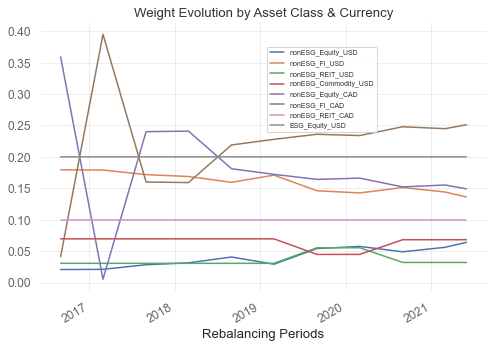

In [39]:
# Plot the weight evolution
x = weights_asset_class.plot.line(figsize=(8,5.5), title = "Weight Evolution by Asset Class & Currency", xlabel = "Rebalancing Periods")
x.legend(loc='center left', bbox_to_anchor=(0.5, 0.75), prop={'size': 7})
x.figure.savefig('weight.png')
print(x)

# Export to Excel
wb = openpyxl.load_workbook(dir + r'\Report.xlsx')
ws = wb['Report']
img = openpyxl.drawing.image.Image(dir + r'\weight.png')
img.anchor = 'Z8' # Or whatever cell location you want to use.
ws.add_image(img)
wb.save(dir + r'\Report.xlsx')

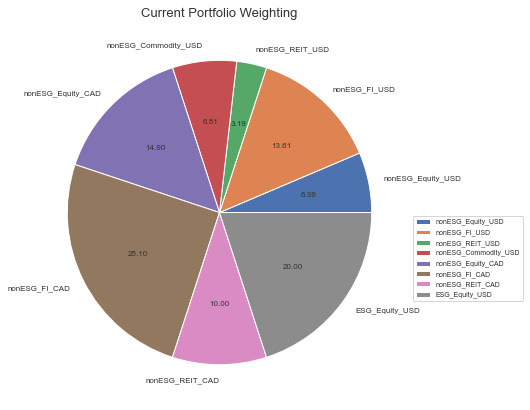

In [40]:
weights_asset_class.index = [''] * 11
weights_asset_class.iloc[-1,:].plot.pie(autopct='%.2f',fontsize=8, figsize=(14, 7),subplots=True)
plt.title("Current Portfolio Weighting",fontsize=13)
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5), prop={'size': 7})
plt.savefig('weighting_pie.png')
plt.show()

# Export to Excel
wb = openpyxl.load_workbook(dir + r'\Report.xlsx')
ws = wb['Report']
img = openpyxl.drawing.image.Image(dir + r'\weighting_pie.png')
img.anchor = 'C5' # Or whatever cell location you want to use.
ws.add_image(img)
wb.save(dir + r'\Report.xlsx')

In [41]:
#Return Attribution version 1 - not consider injection
# compare the final value of each asset class with the initial value of each asset class
# add up the differences together and see the percentage of each asset class takes in the total differences
'''
ret_contribution = (portfValue_wocf[-1]*weights.iloc[-1]-portfValue_wocf[0]*weights.iloc[0])/np.sum(portfValue_wocf[-1]*weights.iloc[-1]-portfValue_wocf[0]*weights.iloc[0])
ret_contribution = pd.DataFrame(ret_contribution).T
retc_asset_class = pd.DataFrame()
retc_asset_class["tickers_nonESG_equity_USD"] = ret_contribution[tickers_nonESG_equity_USD].sum(axis=1)
retc_asset_class["tickers_nonESG_FI_USD"] = ret_contribution[tickers_nonESG_FI_USD].sum(axis=1)
retc_asset_class["tickers_nonESG_REIT_USD"] = ret_contribution[tickers_nonESG_REIT_USD].sum(axis=1)
retc_asset_class["tickers_nonESG_Commodity_USD"] = ret_contribution[tickers_nonESG_Commodity_USD].sum(axis=1)
retc_asset_class["tickers_nonESG_equity_CAD"] = ret_contribution[tickers_nonESG_equity_CAD].sum(axis=1)
retc_asset_class["tickers_nonESG_FI_CAD"] = ret_contribution[tickers_nonESG_FI_CAD].sum(axis=1)
retc_asset_class["tickers_nonESG_REIT_CAD"] = ret_contribution[tickers_nonESG_REIT_CAD].sum(axis=1)
retc_asset_class["tickers_ESG_equity_USD"] = ret_contribution[tickers_ESG_equity_USD].sum(axis=1)

print ("###################Return Attribution###################")
returnAttribution = retc_asset_class.T
print (round(returnAttribution*100,2))
returnAttribution.plot.pie(autopct='%.2f',fontsize=15, figsize=(15, 12),subplots=True)
plt.title("Return Attribution",fontsize=25)
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))
plt.show()
'''

'\nret_contribution = (portfValue_wocf[-1]*weights.iloc[-1]-portfValue_wocf[0]*weights.iloc[0])/np.sum(portfValue_wocf[-1]*weights.iloc[-1]-portfValue_wocf[0]*weights.iloc[0])\nret_contribution = pd.DataFrame(ret_contribution).T\nretc_asset_class = pd.DataFrame()\nretc_asset_class["tickers_nonESG_equity_USD"] = ret_contribution[tickers_nonESG_equity_USD].sum(axis=1)\nretc_asset_class["tickers_nonESG_FI_USD"] = ret_contribution[tickers_nonESG_FI_USD].sum(axis=1)\nretc_asset_class["tickers_nonESG_REIT_USD"] = ret_contribution[tickers_nonESG_REIT_USD].sum(axis=1)\nretc_asset_class["tickers_nonESG_Commodity_USD"] = ret_contribution[tickers_nonESG_Commodity_USD].sum(axis=1)\nretc_asset_class["tickers_nonESG_equity_CAD"] = ret_contribution[tickers_nonESG_equity_CAD].sum(axis=1)\nretc_asset_class["tickers_nonESG_FI_CAD"] = ret_contribution[tickers_nonESG_FI_CAD].sum(axis=1)\nretc_asset_class["tickers_nonESG_REIT_CAD"] = ret_contribution[tickers_nonESG_REIT_CAD].sum(axis=1)\nretc_asset_class["

###################Risk Attribution###################
                          0
nonESG_Equity_USD      7.00
nonESG_FI_USD          4.10
nonESG_REIT_USD        4.72
nonESG_Commodity_USD   3.92
nonESG_Equity_CAD     23.71
nonESG_FI_CAD          8.04
nonESG_REIT_CAD       11.62
ESG_Equity_USD        36.89


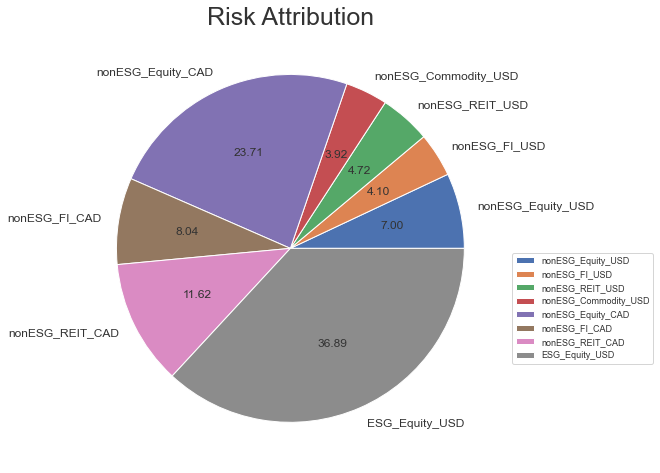

In [42]:
#Risk Attribution
price_portf_1y = price_portf.loc[testDate]  # ETF price for the test period
price_portf_1y = price_portf_1y.pct_change()  # ETF monthly return for the test period
price_portf_1y = price_portf_1y.iloc[1:]
cov_matrix_1y = price_portf_1y.cov()
cov_matrix_1y_mtx = cov_matrix_1y.to_numpy()  # ETF monthly return variance-covariance matrix
latest_weight = weights.iloc[-1]  # the weight for each asset of the last rebalancing period
# calculate the risk contribution of each ETF to the portfolio risk
risk_contribution = calculate_risk_contribution(latest_weight, cov_matrix_1y_mtx)  
risk_contribution = risk_contribution / np.sum(calculate_risk_contribution(latest_weight, cov_matrix_1y_mtx))
risk_contribution = pd.DataFrame(np.array(risk_contribution).T, columns = tickers)
# seperate the risk contribution into asset classes
rc_asset_class = pd.DataFrame()
rc_asset_class["nonESG_Equity_USD"] = risk_contribution[tickers_nonESG_equity_USD].sum(axis=1)
rc_asset_class["nonESG_FI_USD"] = risk_contribution[tickers_nonESG_FI_USD].sum(axis=1)
rc_asset_class["nonESG_REIT_USD"] = risk_contribution[tickers_nonESG_REIT_USD].sum(axis=1)
rc_asset_class["nonESG_Commodity_USD"] = risk_contribution[tickers_nonESG_Commodity_USD].sum(axis=1)
rc_asset_class["nonESG_Equity_CAD"] = risk_contribution[tickers_nonESG_equity_CAD].sum(axis=1)
rc_asset_class["nonESG_FI_CAD"] = risk_contribution[tickers_nonESG_FI_CAD].sum(axis=1)
rc_asset_class["nonESG_REIT_CAD"] = risk_contribution[tickers_nonESG_REIT_CAD].sum(axis=1)
rc_asset_class["ESG_Equity_USD"] = risk_contribution[tickers_ESG_equity_USD].sum(axis=1)

print ("###################Risk Attribution###################")
riskAttribution = rc_asset_class.T
print (round(riskAttribution*100,2))
riskAttribution.columns=['']
riskAttribution[''].plot.pie(autopct='%.2f', fontsize=12, figsize=(16, 8),subplots=True)
plt.title("Risk Attribution",fontsize=25)
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5), prop={'size': 9})
plt.savefig('risk_attribution.png')
plt.show()

# Export to Excel
wb = openpyxl.load_workbook(dir + r'\Report.xlsx')
ws = wb['Report']
img = openpyxl.drawing.image.Image(dir + r'\risk_attribution.png')
img.anchor = 'AL24' # Or whatever cell location you want to use.
ws.add_image(img)
wb.save(dir + r'\Report.xlsx')

book = load_workbook(dir + r'\Report.xlsx')
writer = pd.ExcelWriter(dir + r'\Report.xlsx', engine='openpyxl') 
writer.book = book
writer.sheets = dict((ws.title, ws) for ws in book.worksheets)
round(riskAttribution*100,2).to_excel(writer, sheet_name='Report',startcol=36,startrow=29)
writer.save()

<ipython-input-43-6cf40d0b7052>:11: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  returnAttr=pd.Series()


###################Return Attribution###################
                          0
nonESG_Equity_USD      8.40
nonESG_FI_USD         11.60
nonESG_REIT_USD        3.26
nonESG_Commodity_USD   6.74
nonESG_Equity_CAD      5.18
nonESG_FI_CAD         34.82
nonESG_REIT_CAD       10.00
ESG_Equity_USD        20.00


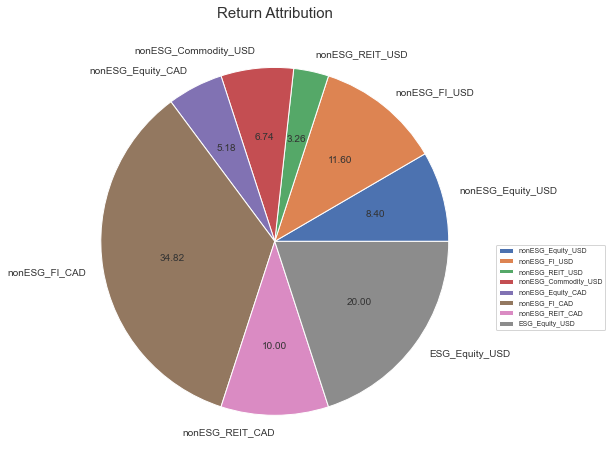

In [43]:
#Return Attribution Version 2 - consider injection
df_pfv = pd.DataFrame(portfValue_wocf, index = testDate) # change array of portfolio values to be dataframe with index of test dates
df_pfv_rb = df_pfv.loc[testDate2] # retreive the portfolio values of rebalancing dates
weights = weights.set_index(testDate2) # set the index of weights to be rebalancing dates
df_pfv_asset = weights.mul(df_pfv_rb.iloc[:,0], axis=0) # get the value of each asset class based on the weights
tickerAll = tickers_nonESG_equity_USD + tickers_nonESG_FI_USD + tickers_nonESG_REIT_USD + tickers_nonESG_Commodity_USD +  tickers_nonESG_equity_CAD + tickers_nonESG_FI_CAD + tickers_nonESG_REIT_CAD + tickers_ESG_equity_USD 
# for each rebalancing period, calculate the value change in all asset classes
valueAdd=[(df_pfv_asset.loc[testDate2[i]:testDate2[i+1],tickerAll].iloc[-1]-df_pfv_asset.loc[testDate2[i]:testDate2[i+1],tickerAll].iloc[0]) for i in range(len(testDate2)-1)]
valueAdd=pd.DataFrame(valueAdd)
# Calculate the sum of value changes of each asset class during all the rebalancing periods with injections removed
returnAttr=pd.Series()
returnAttr['nonESG_Equity_USD']=valueAdd[tickers_nonESG_equity_USD].sum().sum()
returnAttr['nonESG_FI_USD']=valueAdd[tickers_nonESG_FI_USD].sum().sum()
returnAttr['nonESG_REIT_USD']=valueAdd[tickers_nonESG_REIT_USD].sum().sum()
returnAttr['nonESG_Commodity_USD']=valueAdd[tickers_nonESG_Commodity_USD].sum().sum()
returnAttr['nonESG_Equity_CAD']=valueAdd[tickers_nonESG_equity_CAD].sum().sum()
returnAttr['nonESG_FI_CAD']=valueAdd[tickers_nonESG_FI_CAD].sum().sum()
returnAttr['nonESG_REIT_CAD']=valueAdd[tickers_nonESG_REIT_CAD].sum().sum()
returnAttr['ESG_Equity_USD']=valueAdd[tickers_ESG_equity_USD].sum().sum()
returnAttr["Return Attribution"]=returnAttr*(portfValue_wocf[-1]-100000-10000*10)/returnAttr.sum()

print ("###################Return Attribution###################")
df = returnAttr["Return Attribution"]
df= (round((df/df.sum())*100,2))
df=pd.DataFrame(df)
print (df)
df.columns=[""]
df[""].plot.pie(autopct='%.2f', fontsize=10, figsize=(16, 8))
plt.title("Return Attribution",fontsize=15)
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5), prop={'size': 7})
plt.savefig('return_attribution2.png')
plt.show()

# Export to Excel
wb = openpyxl.load_workbook(dir + r'\Report.xlsx')
ws = wb['Report']
img = openpyxl.drawing.image.Image(dir + r'\return_attribution2.png')
img.anchor = 'AL4' # Or whatever cell location you want to use.
ws.add_image(img)
wb.save(dir + r'\Report.xlsx')

book = load_workbook(dir + r'\Report.xlsx')
writer = pd.ExcelWriter(dir + r'\Report.xlsx', engine='openpyxl') 
writer.book = book
writer.sheets = dict((ws.title, ws) for ws in book.worksheets)
df.to_excel(writer, sheet_name='Report',startcol=36,startrow=9)
writer.save()

In [44]:
from openpyxl.styles import Border, Side, PatternFill, Font, GradientFill, Alignment

bottom_border = Border(bottom=Side(style='thin'))
l_border = Border(top=Side(style='thin'), left=Side(style='thin'))
r_border = Border(top=Side(style='thin'), right=Side(style='thin'))

font = Font(name='Calibri', size=11, bold=False, vertAlign=None, color='FF000000')
number_format = '0.00%'
date_format = 'yyyy-mm-dd'
fill = PatternFill("solid", fgColor="DDDDDD")

wb = openpyxl.load_workbook(dir + r'\Report.xlsx')
ws = wb['Report']
# property cell.border should be used instead of cell.style.border
#ws['B61'].border = thin_border
#ws['B62'].border = thin_border
#ws['B63'].border = thin_border
#ws['B63'].fill = fill
ws['C5'].number_format = date_format
ws['C6'].number_format = date_format
ws['C8'].number_format = number_format
ws['C9'].number_format = number_format
ws['C10'].number_format = number_format
ws['C11'].number_format = number_format
ws['C12'].number_format = number_format
ws['C13'].number_format = number_format
ws['C18'].number_format = number_format
ws['C19'].number_format = number_format
ws['C20'].number_format = number_format
ws['C25'].number_format = number_format
ws['C26'].number_format = number_format
ws['C27'].number_format = number_format
ws['C28'].number_format = number_format

ws['AK10'].border = l_border
ws['AL10'].border = r_border
ws.merge_cells('AK10:AL10')
ws['AK10'].alignment = Alignment(horizontal="center", vertical="center")

ws['AK30'].border = l_border
ws['AL30'].border = r_border
ws.merge_cells('AK30:AL30')
ws['AK30'].alignment = Alignment(horizontal="center", vertical="center")


wb.save(dir + r'\Report.xlsx')